<a href="https://colab.research.google.com/github/g-gutierr/senpai-gan-flask/blob/master/Proyecto_Senpai_AI_dev_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Senpai AI dev 2020 


## 1 - Cargar los datos

In [ ]:
# Descarga dataset

# pip install gdown
!gdown 'https://drive.google.com/uc?id=1LHeNOli_lvObLlNQ1vn4L3B8ndNeNgV8'
!gdown 'https://drive.google.com/uc?id=1Lz60wW87QxVVYnUYXJDZRYusbqspi6Xv'
!gdown 'https://drive.google.com/uc?id=1rsvTUlaZCxzewj-vtHrWuGDJ-Q9h86MF'
!gdown 'https://drive.google.com/uc?id=1c5xvjK1KM7XK_m2nQQetlAkPJIydG3sZ'

Downloading...
From: https://drive.google.com/uc?id=1LHeNOli_lvObLlNQ1vn4L3B8ndNeNgV8
To: /content/sv_data.z01
734MB [00:04, 175MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Lz60wW87QxVVYnUYXJDZRYusbqspi6Xv
To: /content/sv_data.z02
734MB [00:12, 60.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rsvTUlaZCxzewj-vtHrWuGDJ-Q9h86MF
To: /content/sv_data.z03
734MB [00:17, 40.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1c5xvjK1KM7XK_m2nQQetlAkPJIydG3sZ
To: /content/sv_data.zip
322MB [00:05, 62.2MB/s]


In [ ]:
# Descomprime dataset

!zip -F sv_data.zip --out combined.zip
!unzip -P d89551fd190e38 combined.zip

Streaming output truncated to the last 5000 lines.
  inflating: sv_data/image/73/56f2f91badda2d.jpg  
  inflating: sv_data/image/73/57d10d3a32eb1a.jpg  
  inflating: sv_data/image/73/592493337750e7.jpg  
  inflating: sv_data/image/73/598ae25cd5b9f4.jpg  
  inflating: sv_data/image/73/5a0c024428a674.jpg  
  inflating: sv_data/image/73/5a23af839e1029.jpg  
  inflating: sv_data/image/73/5b0f288333d0c1.jpg  
  inflating: sv_data/image/73/5b27c3fa4a950f.jpg  
  inflating: sv_data/image/73/5b2962c1e14c9f.jpg  
  inflating: sv_data/image/73/5b2bbe007a9eee.jpg  
  inflating: sv_data/image/73/5b60d0d70ef437.jpg  
  inflating: sv_data/image/73/5c4f898c068d86.jpg  
  inflating: sv_data/image/73/5c7ecdc74cf057.jpg  
  inflating: sv_data/image/73/5d8f4b6fb8da9d.jpg  
  inflating: sv_data/image/73/5e10606b0b01cc.jpg  
  inflating: sv_data/image/73/5eecae3c351575.jpg  
  inflating: sv_data/image/73/5f27537818c39d.jpg  
  inflating: sv_data/image/73/5f7447c96b06bf.jpg  
  inflating: sv_data/image/73/5

In [ ]:
# imports

import os
from os import listdir

import numpy as np

from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from PIL import Image
from IPython import display
from tqdm import tqdm

import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, Conv2DTranspose, Reshape, Conv2D, BatchNormalization, Flatten, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

Using TensorFlow backend.


In [ ]:
# constantes

seed_value = 0
np.random.seed(seed_value)
# tf.random.set_seed(seed_value)

# path del directorio con las imagenes del dataset
dataset_path = 'sv_data/image/'

# path del guardado de los modelos y pesos
model_path = 'model_gan.h5'

# cantidad de imagenes a ser cargadas en memoria, 
# None hace que se ignore la variable
n_images_to_load = None

# cantidad de imagenes utilizadas por directorio, 
# None hace que se ignore la variable
n_images_per_dir = None

# cantidad de imagenes a ser utilizadas en el entrenamiento, 
# None hace que se ignore la variable
n_images_to_train = None

noise_dim = 100
image_dim = (32, 32)

In [ ]:
# define functions

def open_image(file_path):
  return Image.open(file_path)  

def resize_image(image, image_dim = (32, 32)):
  return image.resize(image_dim, Image.ANTIALIAS)

def plot_image(image):
  plt.imshow(image)

def load_image_array(file_path):
  image = open_image(file_path)
  resized_image = resize_image(image)
  pixels = np.asarray(resized_image)
  return pixels

def show_image(file_path):
  image = open_image(file_path)
  plot_image(image)

def show_image_array(image_array):
  plot_image(image_array)

def load_cars(top_directory, n_cars = None, per_brand = None):
  loaded_cars = []
  for brand_directory in listdir(top_directory):
    for file_num, file_name in enumerate(listdir(os.path.join(top_directory, brand_directory))):
      if per_brand != None and file_num > per_brand:
        break;

      car_array = load_image_array(os.path.join(top_directory, brand_directory, file_name))

      loaded_cars.append(car_array)

      # remove this print when release
      if (len(loaded_cars) % 1000 == 0):
        print(len(loaded_cars))

      if n_cars != None and len(loaded_cars) == n_cars:
        return np.asarray(loaded_cars)

  return np.asarray(loaded_cars)

def show_samples(cars):
  num_rows = 3
  num_cols = 12
  fig_size=(20, 5)

  index = np.random.choice(cars.shape[0], num_rows * num_cols, replace=False)
  samples = cars[index,:,:,:]
  plt.figure(figsize=fig_size)
  for i in range(samples.shape[0]):
    plt.subplot(num_rows, num_cols, i + 1)
    img = samples[i,:,:,:]
    plt.imshow(img)
    plt.axis('off')
  plt.tight_layout()
  plt.show()


def scale_range_minusone_one(X):
  return (X.astype('float32') - 127.5) / 127.5


In [ ]:
%%time

# Esto toma su tiempo, en google colab son 10 minutos aprox.
cars = load_cars(dataset_path, n_images_to_load, n_images_per_dir)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
CPU times: user 9min 59s, sys: 2.81 s, total: 10min 1s
Wall time: 10min 2s


In [ ]:
# vemos la forma de nuestros datos cargados
print(cars.shape)

(44481, 32, 32, 3)


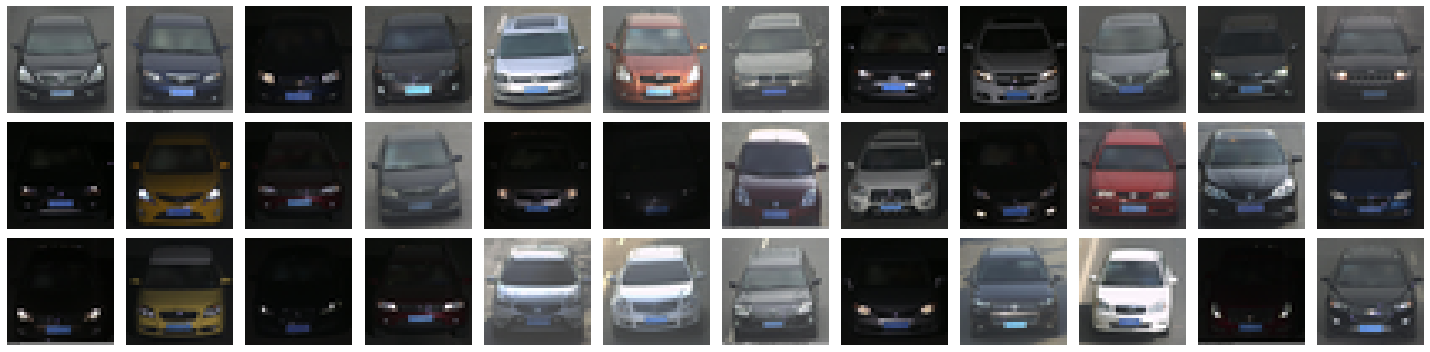

In [ ]:
# mostramos algunos ejemplares
show_samples(cars)

In [ ]:
# removemos los autos oscuros
clear_threshold = 35
clear_cars = np.asarray([car for car in cars if car.mean() > clear_threshold])

# vemos la forma de los autos claros
print(clear_cars.shape)

(30526, 32, 32, 3)


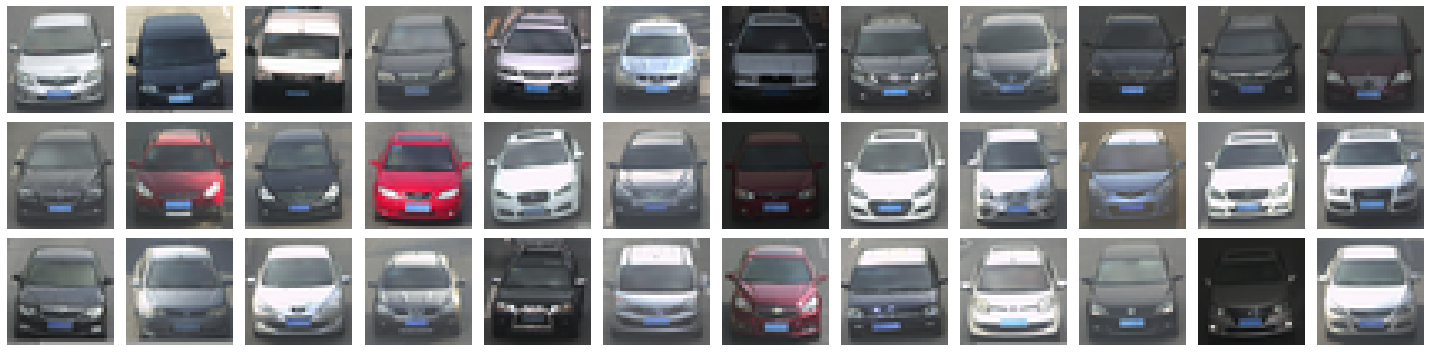

In [ ]:
# mostramos algunos ejemplares
show_samples(clear_cars)

In [ ]:
# Normalizo 
print(clear_cars.min(), clear_cars.max())

X_train = scale_range_minusone_one(clear_cars)

print(X_train.min(), X_train.max())

0 255
-1.0 1.0


## 2 - Crear modelo para el generador

In [ ]:
# Define Generator

def define_generator(noise_dim):
  n_nodes = 4 * 4 * 256
  generator = Sequential()
  generator.add(Dense(n_nodes, input_dim=noise_dim))
  generator.add(LeakyReLU(0.2))
  generator.add(Reshape((4, 4, 256)))
  generator.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding='same'))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(0.2))
  generator.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding='same'))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(0.2))
  generator.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding='same'))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(0.2))
  generator.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
  return generator

In [ ]:
generator = define_generator(100)
generator.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 8, 8, 128)         524416    
_________________________________________________________________
batch_normalization_36 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 16, 16, 128)     

## 3 - Crear modelo para el discriminador


In [ ]:
# Define Discriminator

def define_discriminator(img_dim):
  discriminator = Sequential()
  discriminator.add(Conv2D(64, (3, 3), padding='same', input_shape=img_dim))

  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Conv2D(256, (4,4), strides=(2, 2), padding='same'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Flatten())
  discriminator.add(Dropout(0.4))
  discriminator.add(Dense(1, activation='sigmoid'))

  discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
  return discriminator

In [ ]:
discriminator = define_discriminator((32,32,3))
discriminator.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_39 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 128)       131200    
_________________________________________________________________
batch_normalization_40 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 8, 8, 128)       

## 4 - Generar el GAN

In [ ]:
def define_gan(g_model,d_model):
    d_model.trainable = False

    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1 =0.5)
    model.compile(loss = 'binary_crossentropy', optimizer=opt)
    return model

In [ ]:
gan = define_gan(generator,discriminator)
gan.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_16 (Sequential)   (None, 32, 32, 3)         1467651   
_________________________________________________________________
sequential_17 (Sequential)   (None, 1)                 926209    
Total params: 2,393,860
Trainable params: 1,466,883
Non-trainable params: 926,977
_________________________________________________________________


## 5 - Entrenar el GAN

In [ ]:
# definimos funciones auxiliares

def generate_latent_points(n_samples, noise_dim = 100):
  return np.random.normal(0, 1, size=[n_samples, noise_dim])

def generate_fake_samples(n_samples):
  latent_points = generate_latent_points(n_samples)
  X = generator.predict(latent_points)
  y = np.zeros((n_samples, 1))
  return X, y

def generate_real_samples(n_samples):  
  choices = np.random.choice(X_train.shape[0], size=n_samples, replace=False)
  X = X_train[choices,:,:,:]
  y = np.ones((n_samples, 1))
  return X, y

def plot_loss(losses, clear_output=True):
  if clear_output:
    display.clear_output(wait=True)
    
  display.display(plt.gcf())
  plt.figure(figsize=(10,8))
  plt.plot(losses["d_fake"], label='Discriminator Fake Image Loss')
  plt.plot(losses["d_real"], label='Discriminator Real Image Loss')
  plt.plot(losses["g"], label='Generator Loss')
  plt.legend()
  plt.show()


def plot_gen(n_ex=16,dim=(4,4), figsize=(7,7) ):
    noise = np.random.normal(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,:]

        # mover esto a una funcion
        img = (img + 1) / 2

        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Defino un vector de pérdidas del generador y discriminador
losses = {"d_fake":[], "d_real": [], "g":[]}

In [ ]:
def train_discriminator(discriminator, batch_size):
  half_batch = batch_size // 2

  X_real, y_real = generate_real_samples(half_batch)
  loss_real = discriminator.train_on_batch(X_real, y_real)

  X_fake, y_fake = generate_fake_samples(half_batch)
  loss_fake = discriminator.train_on_batch(X_fake, y_fake)

  # TODO: estamos retornando el loss sobre los fake, habría que separarlo

  return loss_fake, loss_real

In [ ]:
def train_generator(gan, batch_size, noise_dim=100):
  X = generate_latent_points(batch_size, noise_dim)
  y = np.ones((batch_size, 1))
  loss = gan.train_on_batch(X, y)

  return loss

In [ ]:
def train(generator, discriminator, gan, n_epochs=1000, batch_size=32, noise_dim=100):
  X_length = X_train.shape[0]
  batch_per_epoch = X_length // batch_size

  for current_epoch in tqdm(range(0, n_epochs)):
    for current_batch in range(0, batch_per_epoch):
      last_d_fake_loss, last_d_real_loss = train_discriminator(discriminator, batch_size)
      last_g_loss = train_generator(gan, batch_size)

    losses["d_fake"].append(last_d_fake_loss)
    losses["d_real"].append(last_d_real_loss)
    losses["g"].append(last_g_loss)
    
    if current_epoch % 3 == 0:
      plot_loss(losses, False) # deshabilitamos el limpiado de pantalla para la defensa
      plot_gen()

  # some info log
  print('\n\nX_train.shape:', X_train.shape)
  print('n_epochs:', n_epochs)
  print('batch_size:', batch_size)
  print('batch_per_epoch:', batch_per_epoch)

 *Preentrenar el discriminador: TODO*











  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

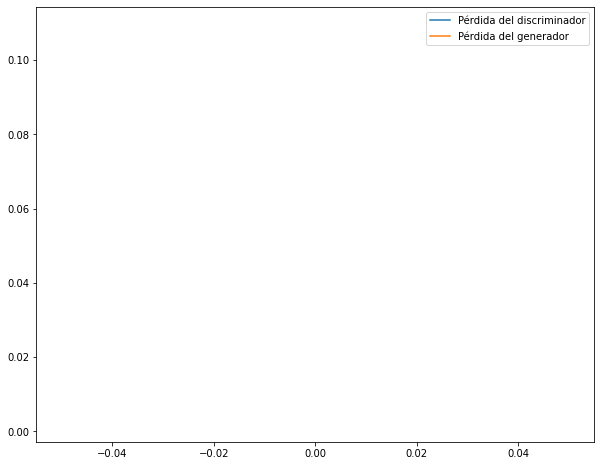

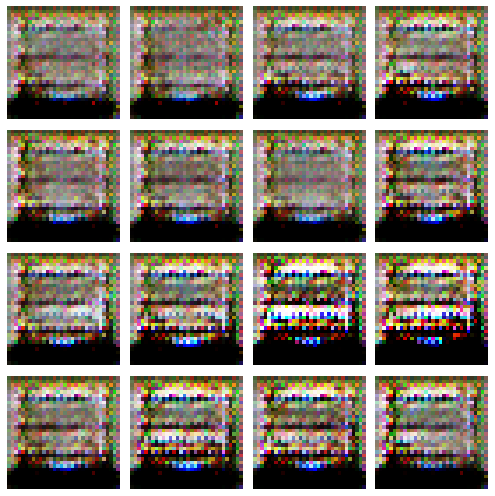











  0%|          | 1/200 [00:40<2:13:12, 40.17s/it]









  1%|          | 2/200 [01:15<2:07:30, 38.64s/it]









  2%|▏         | 3/200 [01:50<2:03:33, 37.63s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

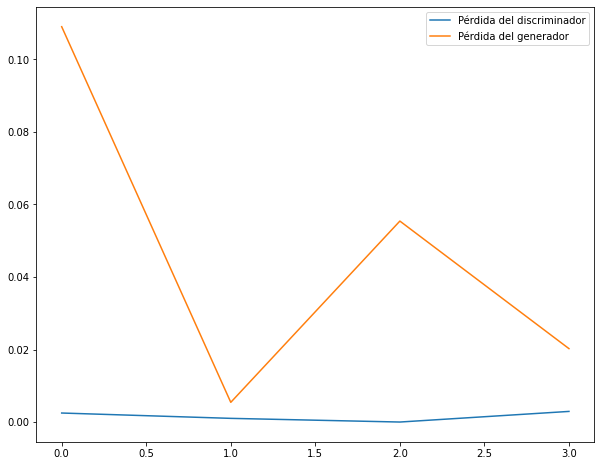

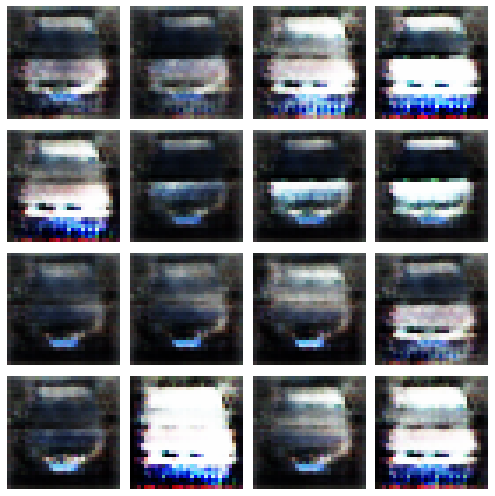











  2%|▏         | 4/200 [02:26<2:01:29, 37.19s/it]









  2%|▎         | 5/200 [03:01<1:58:59, 36.61s/it]









  3%|▎         | 6/200 [03:37<1:57:13, 36.25s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

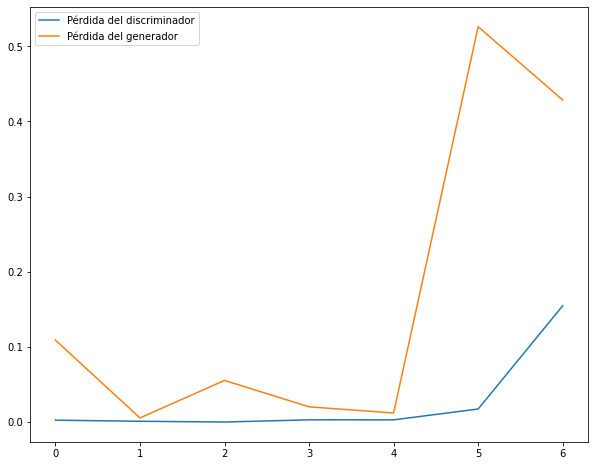

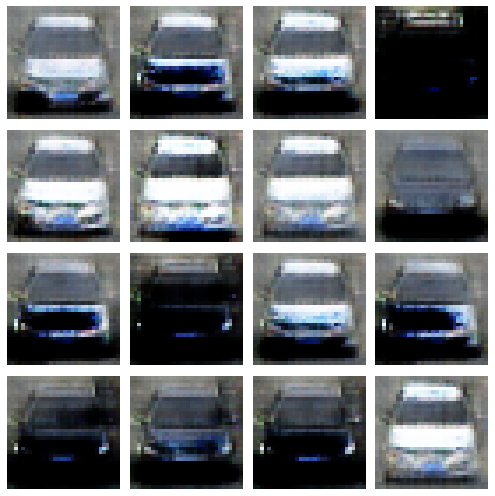











  4%|▎         | 7/200 [04:13<1:56:04, 36.08s/it]









  4%|▍         | 8/200 [04:48<1:54:24, 35.75s/it]









  4%|▍         | 9/200 [05:22<1:52:54, 35.47s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

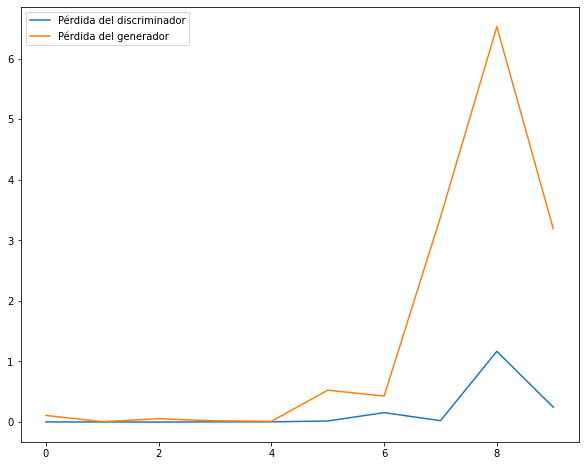

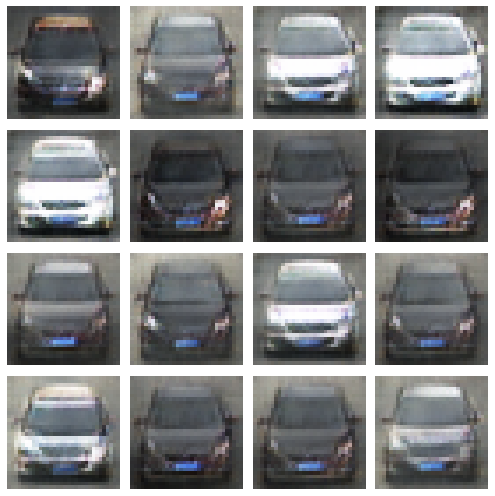











  5%|▌         | 10/200 [05:58<1:52:15, 35.45s/it]









  6%|▌         | 11/200 [06:33<1:51:00, 35.24s/it]









  6%|▌         | 12/200 [07:07<1:49:57, 35.09s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

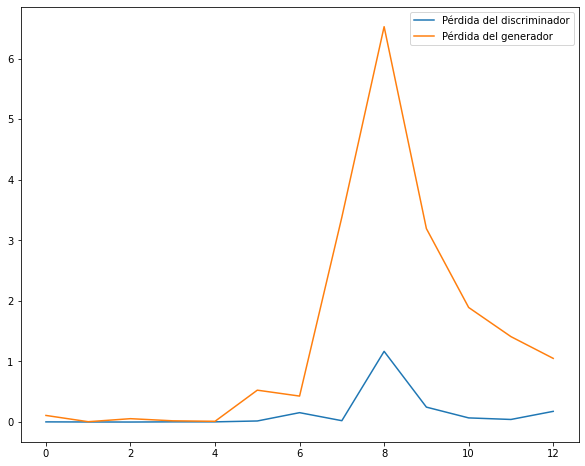

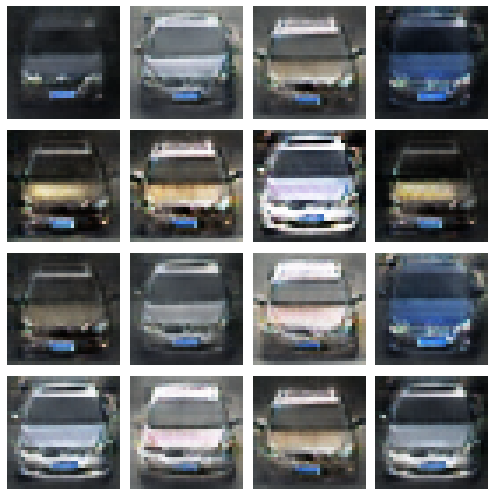











  6%|▋         | 13/200 [07:43<1:49:52, 35.26s/it]









  7%|▋         | 14/200 [08:18<1:48:47, 35.09s/it]









  8%|▊         | 15/200 [08:52<1:47:51, 34.98s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

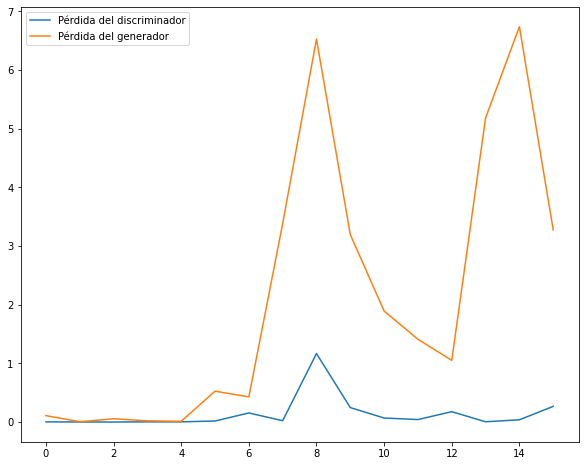

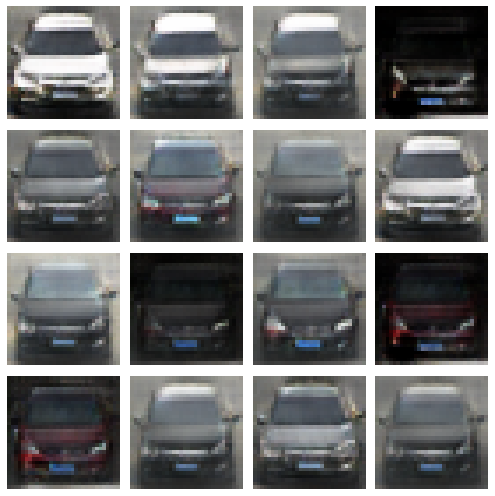











  8%|▊         | 16/200 [09:28<1:47:55, 35.19s/it]









  8%|▊         | 17/200 [10:03<1:47:27, 35.23s/it]









  9%|▉         | 18/200 [10:38<1:46:39, 35.16s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

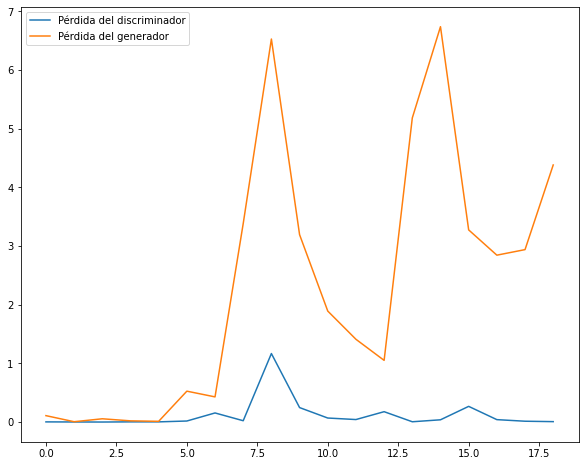

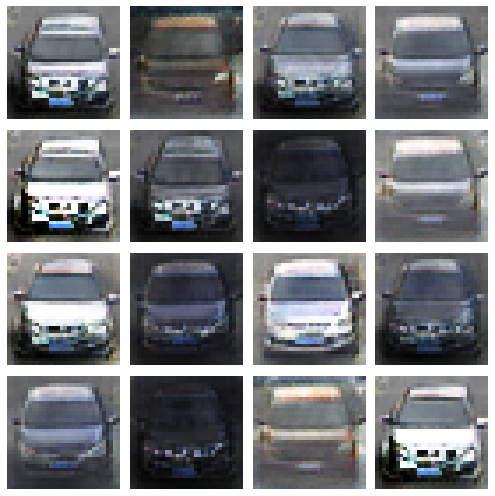











 10%|▉         | 19/200 [11:14<1:46:34, 35.33s/it]









 10%|█         | 20/200 [11:49<1:45:39, 35.22s/it]









 10%|█         | 21/200 [12:24<1:44:55, 35.17s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

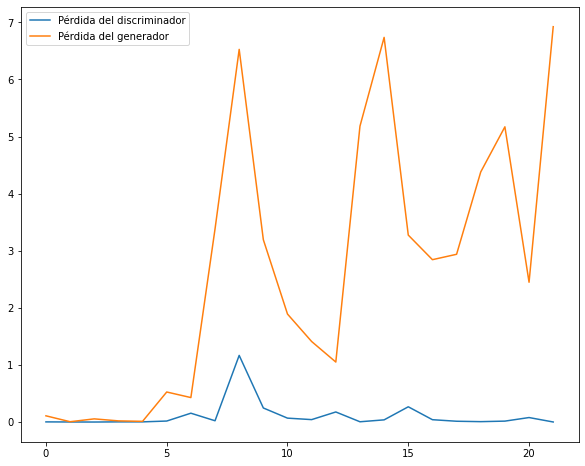

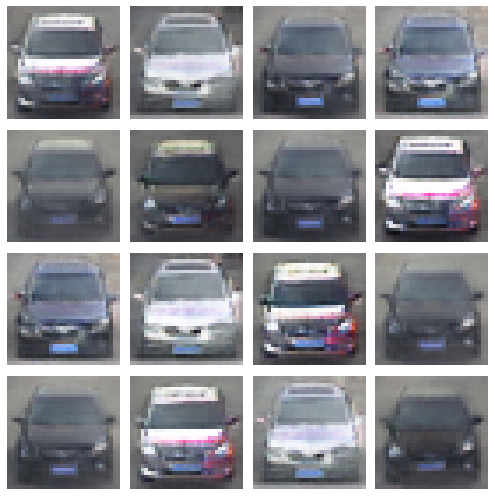











 11%|█         | 22/200 [13:00<1:45:14, 35.48s/it]









 12%|█▏        | 23/200 [13:35<1:44:14, 35.34s/it]









 12%|█▏        | 24/200 [14:10<1:43:27, 35.27s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

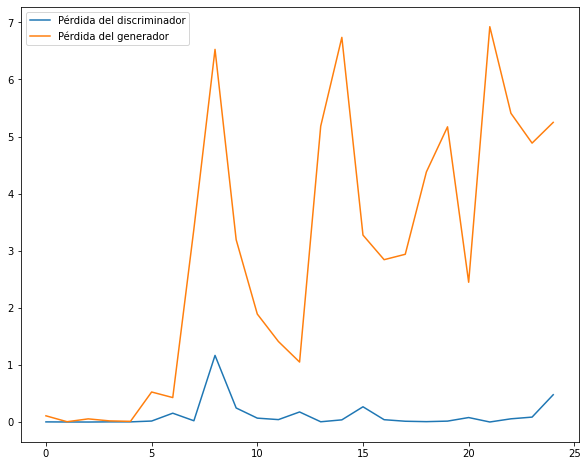

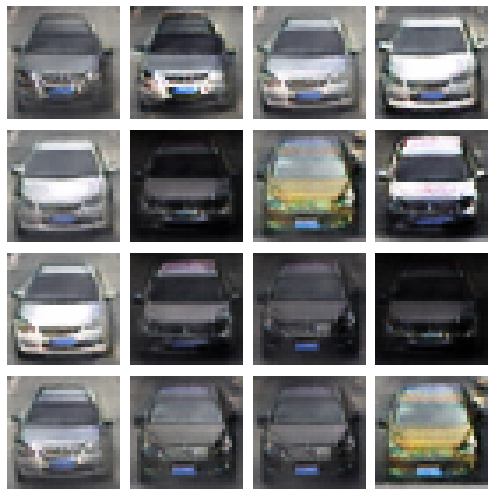











 12%|█▎        | 25/200 [14:46<1:43:26, 35.46s/it]









 13%|█▎        | 26/200 [15:22<1:42:46, 35.44s/it]









 14%|█▎        | 27/200 [15:57<1:41:55, 35.35s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

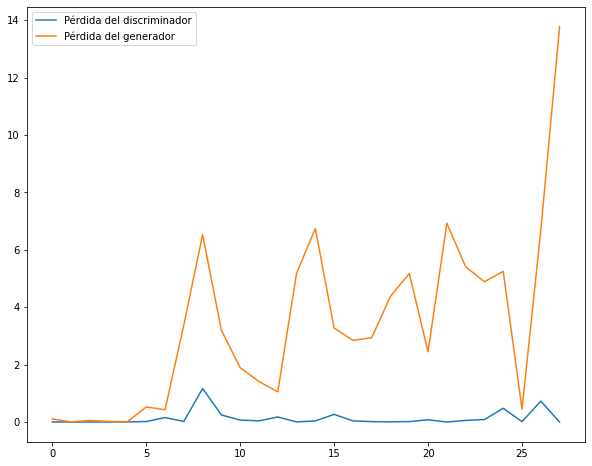

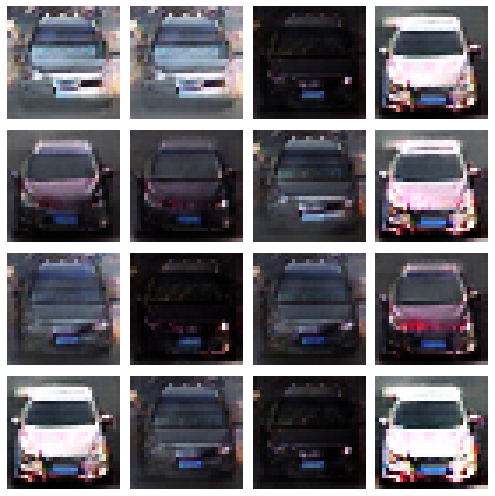











 14%|█▍        | 28/200 [16:33<1:41:45, 35.50s/it]









 14%|█▍        | 29/200 [17:08<1:40:55, 35.41s/it]









 15%|█▌        | 30/200 [17:43<1:40:07, 35.34s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

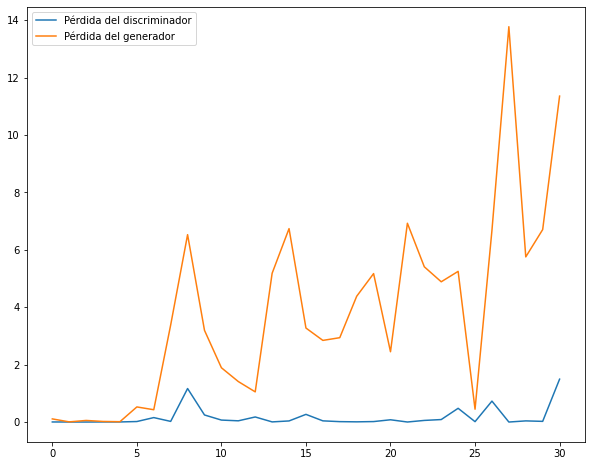

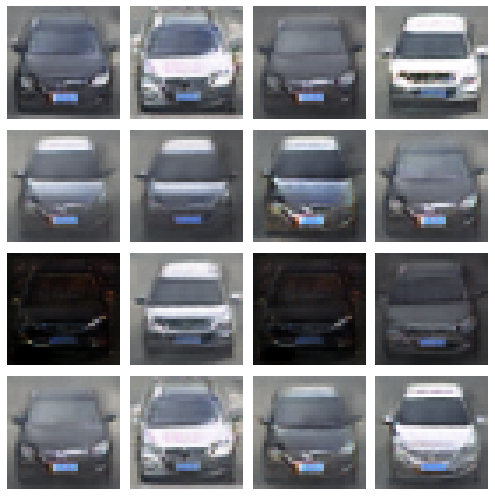











 16%|█▌        | 31/200 [18:19<1:40:15, 35.59s/it]









 16%|█▌        | 32/200 [18:54<1:39:15, 35.45s/it]









 16%|█▋        | 33/200 [19:29<1:38:07, 35.25s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

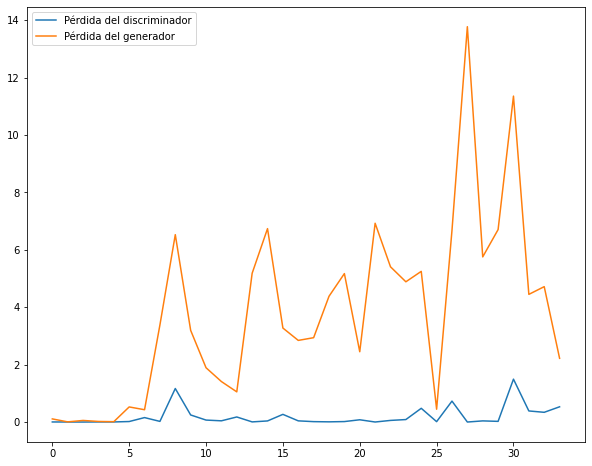

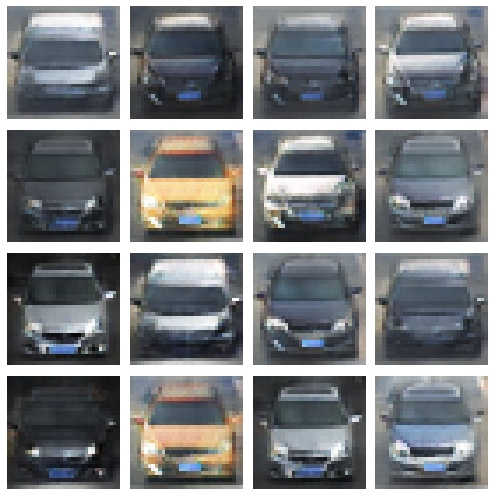











 17%|█▋        | 34/200 [20:04<1:37:31, 35.25s/it]









 18%|█▊        | 35/200 [20:39<1:36:34, 35.12s/it]









 18%|█▊        | 36/200 [21:14<1:35:35, 34.97s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

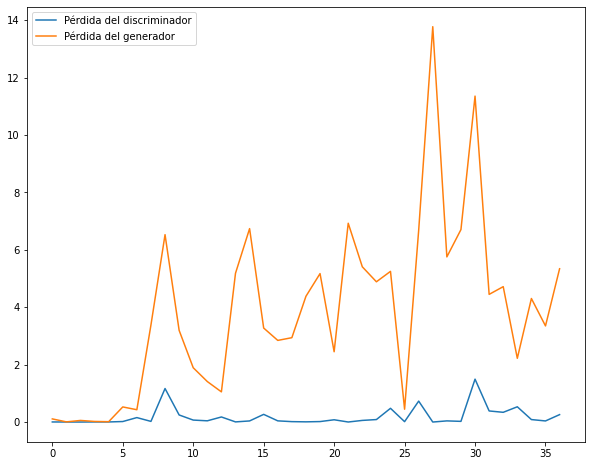

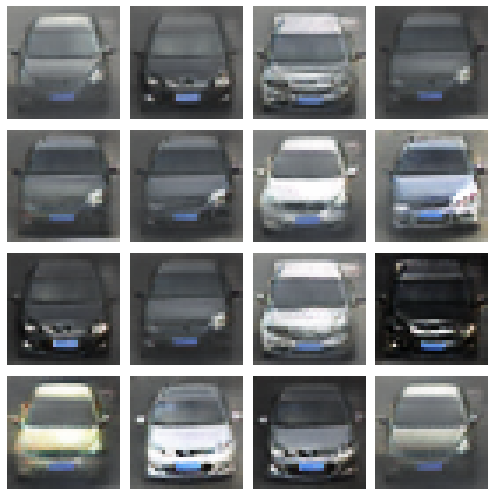











 18%|█▊        | 37/200 [21:49<1:35:11, 35.04s/it]









 19%|█▉        | 38/200 [22:24<1:34:17, 34.92s/it]









 20%|█▉        | 39/200 [22:58<1:33:35, 34.88s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

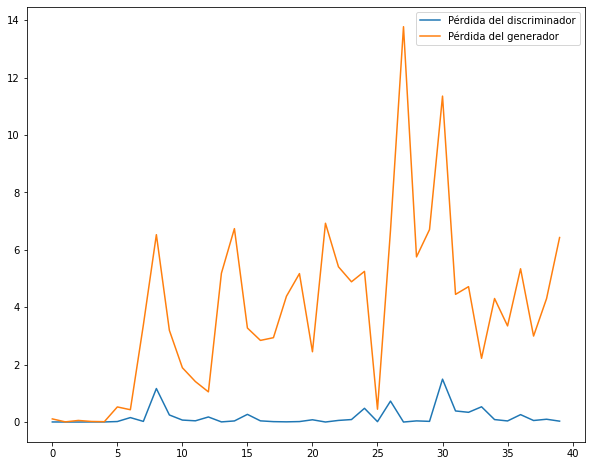

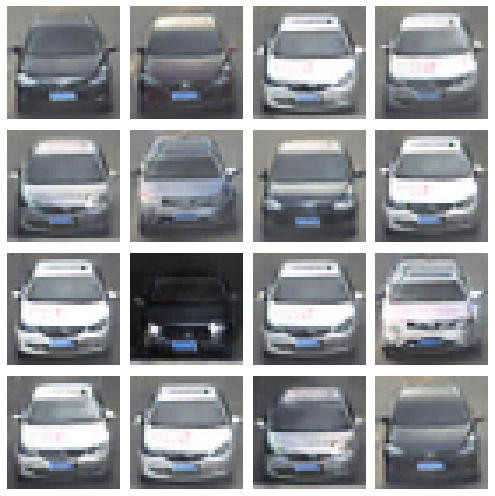











 20%|██        | 40/200 [23:34<1:33:28, 35.05s/it]









 20%|██        | 41/200 [24:09<1:32:47, 35.01s/it]









 21%|██        | 42/200 [24:43<1:31:53, 34.89s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

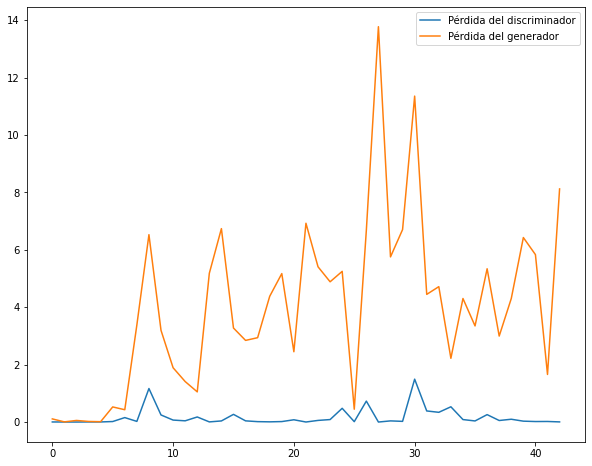

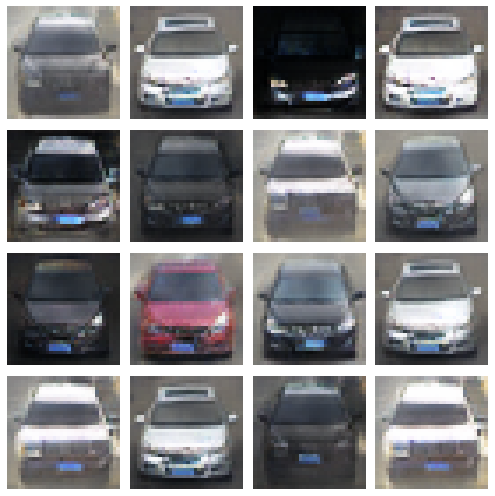











 22%|██▏       | 43/200 [25:19<1:31:34, 35.00s/it]









 22%|██▏       | 44/200 [25:53<1:30:40, 34.88s/it]









 22%|██▎       | 45/200 [26:28<1:29:54, 34.80s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

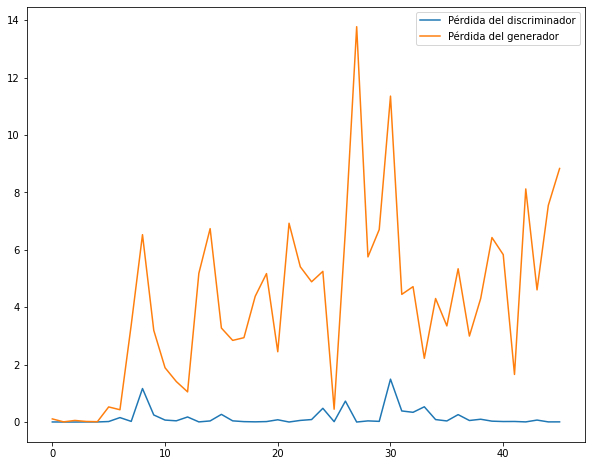

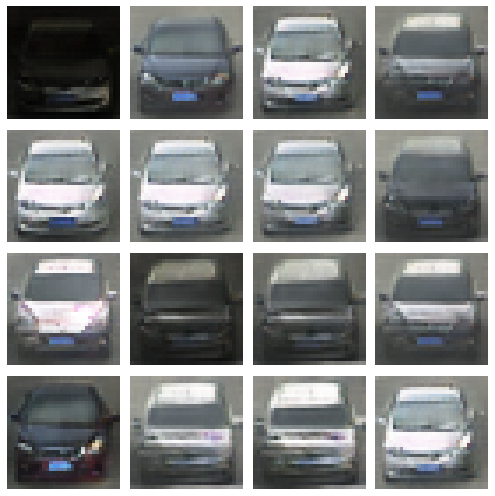











 23%|██▎       | 46/200 [27:03<1:29:35, 34.91s/it]









 24%|██▎       | 47/200 [27:38<1:28:47, 34.82s/it]









 24%|██▍       | 48/200 [28:13<1:28:13, 34.83s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

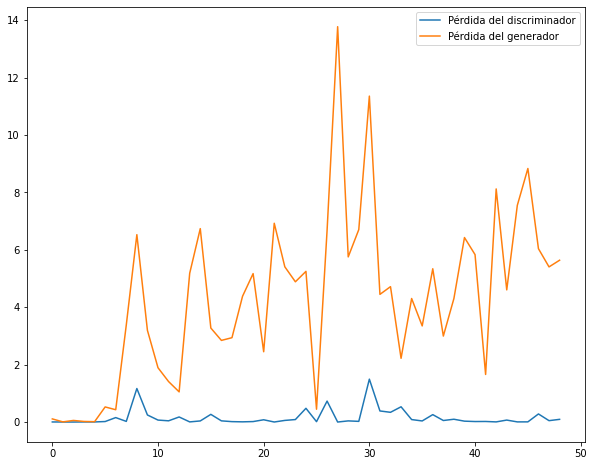

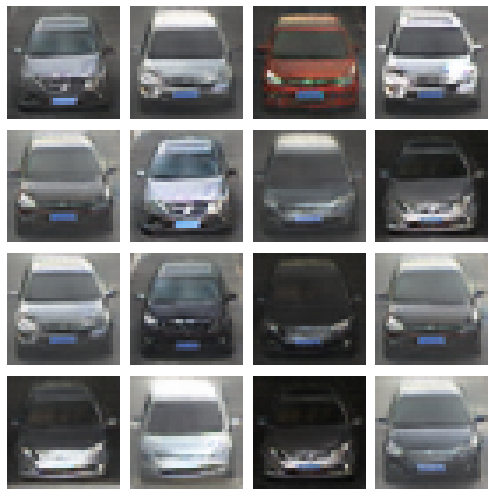











 24%|██▍       | 49/200 [28:48<1:27:58, 34.96s/it]









 25%|██▌       | 50/200 [29:22<1:27:05, 34.84s/it]









 26%|██▌       | 51/200 [29:57<1:26:19, 34.76s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

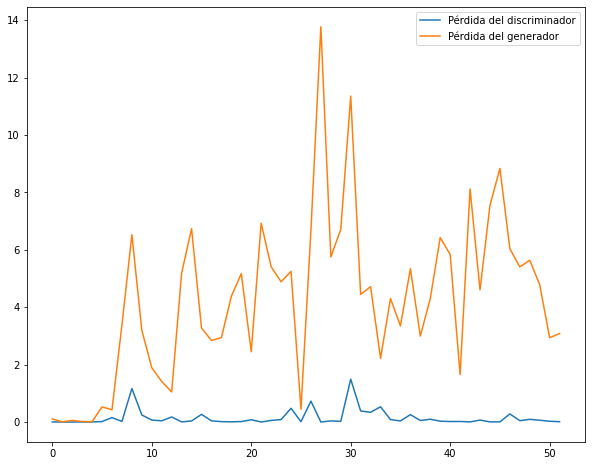

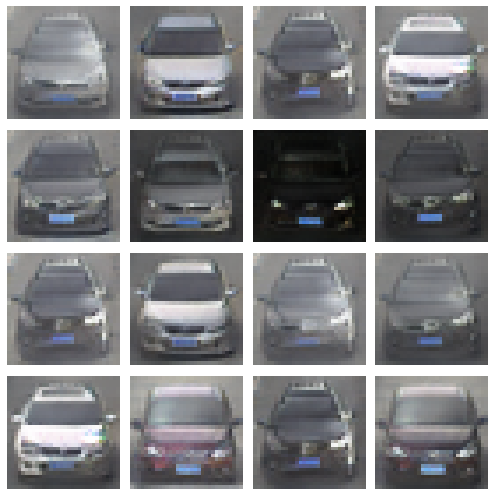











 26%|██▌       | 52/200 [30:32<1:26:07, 34.92s/it]









 26%|██▋       | 53/200 [31:07<1:25:17, 34.81s/it]









 27%|██▋       | 54/200 [31:41<1:24:32, 34.75s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

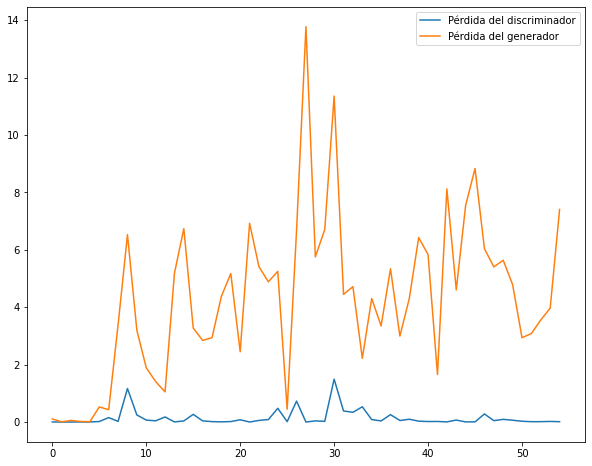

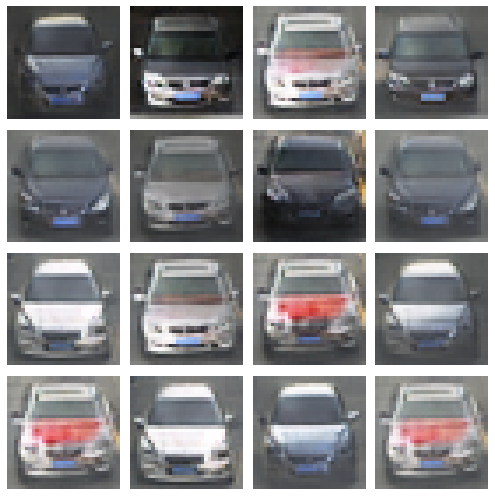











 28%|██▊       | 55/200 [32:16<1:24:14, 34.86s/it]









 28%|██▊       | 56/200 [32:51<1:23:29, 34.79s/it]









 28%|██▊       | 57/200 [33:26<1:23:01, 34.83s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

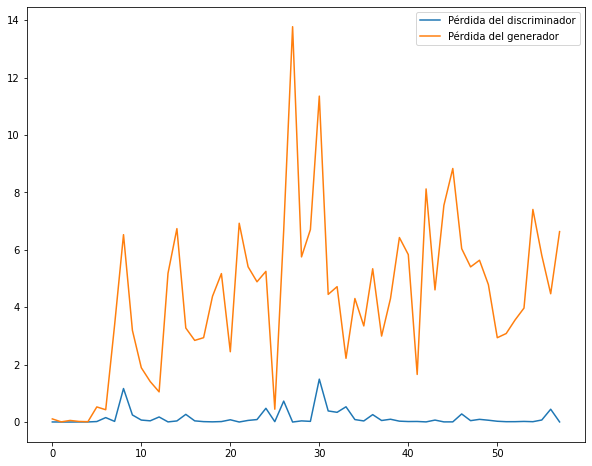

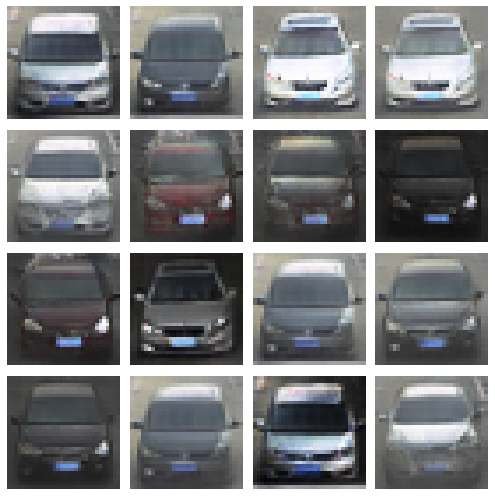











 29%|██▉       | 58/200 [34:02<1:22:56, 35.05s/it]









 30%|██▉       | 59/200 [34:36<1:22:03, 34.92s/it]









 30%|███       | 60/200 [35:11<1:21:16, 34.83s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

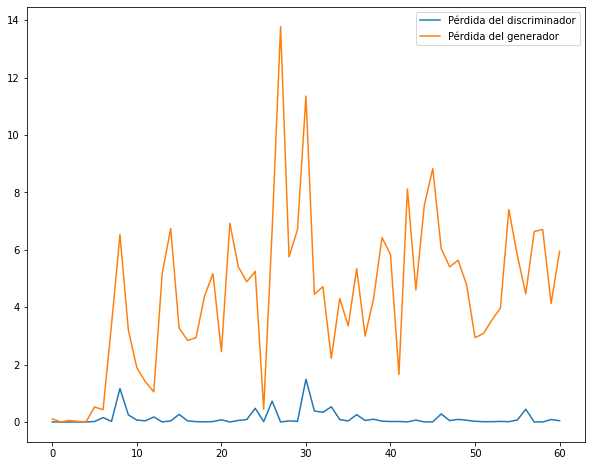

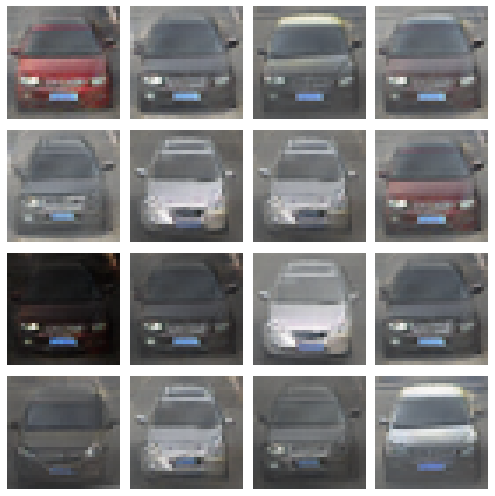











 30%|███       | 61/200 [35:46<1:21:02, 34.98s/it]









 31%|███       | 62/200 [36:21<1:20:09, 34.85s/it]









 32%|███▏      | 63/200 [36:55<1:19:26, 34.79s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

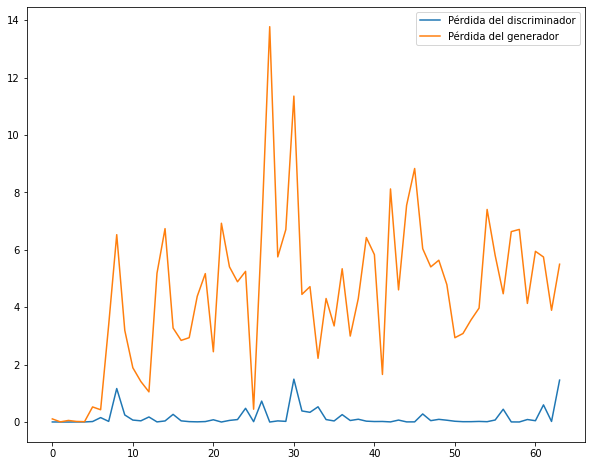

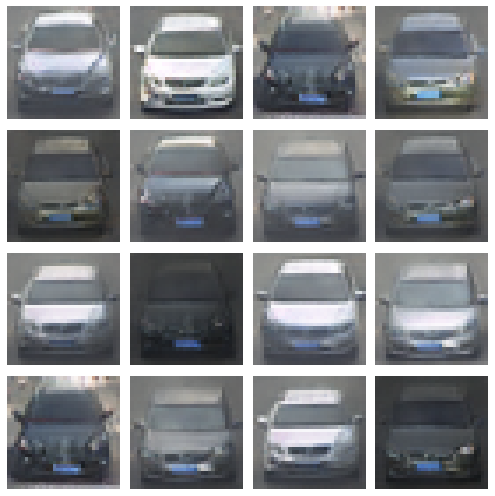











 32%|███▏      | 64/200 [37:31<1:19:05, 34.90s/it]









 32%|███▎      | 65/200 [38:05<1:18:23, 34.84s/it]









 33%|███▎      | 66/200 [38:40<1:17:50, 34.86s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

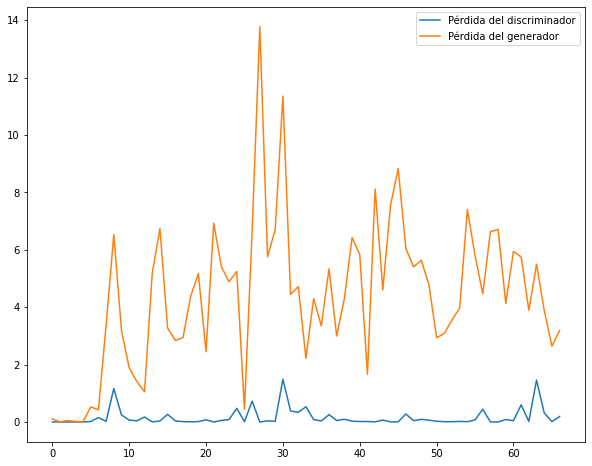

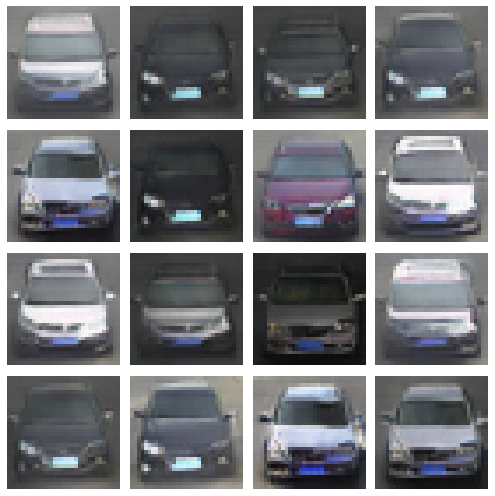











 34%|███▎      | 67/200 [39:15<1:17:29, 34.96s/it]









 34%|███▍      | 68/200 [39:50<1:16:40, 34.86s/it]









 34%|███▍      | 69/200 [40:25<1:15:56, 34.78s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

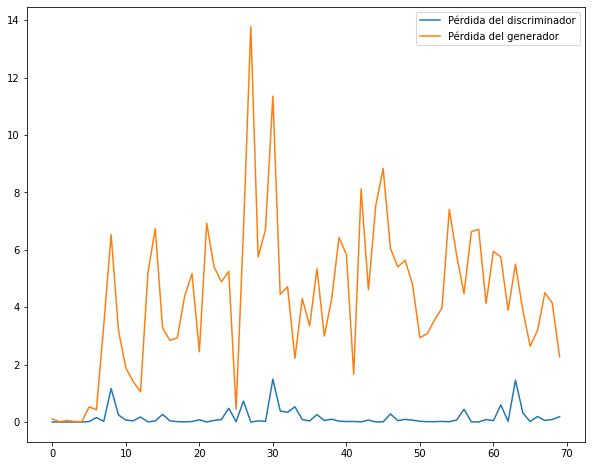

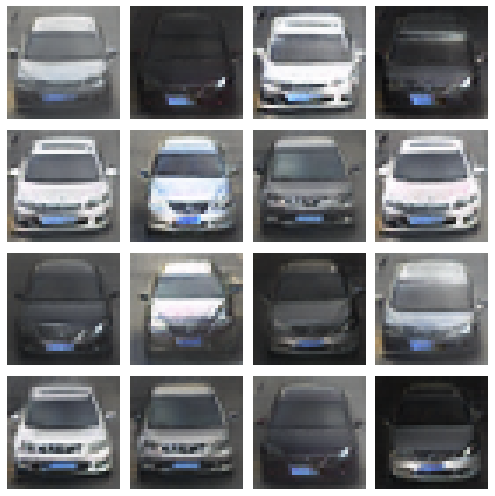











 35%|███▌      | 70/200 [41:00<1:15:42, 34.94s/it]









 36%|███▌      | 71/200 [41:34<1:14:53, 34.84s/it]









 36%|███▌      | 72/200 [42:09<1:14:11, 34.78s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

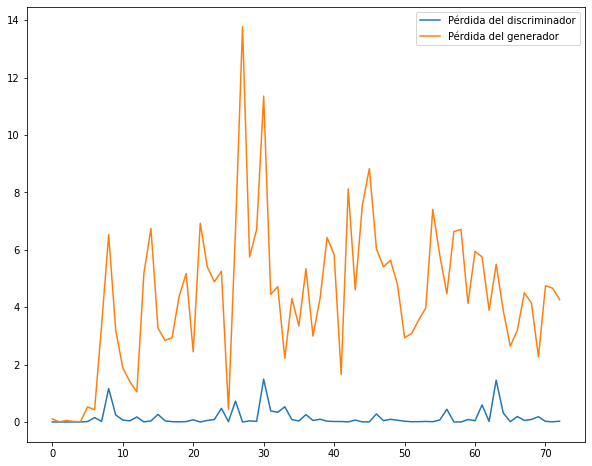

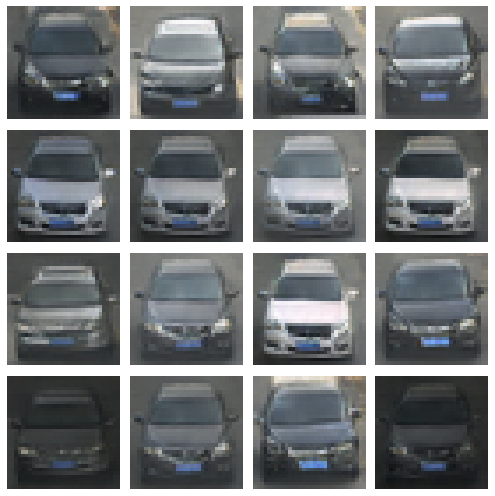











 36%|███▋      | 73/200 [42:44<1:13:50, 34.88s/it]









 37%|███▋      | 74/200 [43:19<1:13:05, 34.81s/it]









 38%|███▊      | 75/200 [43:54<1:12:36, 34.85s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

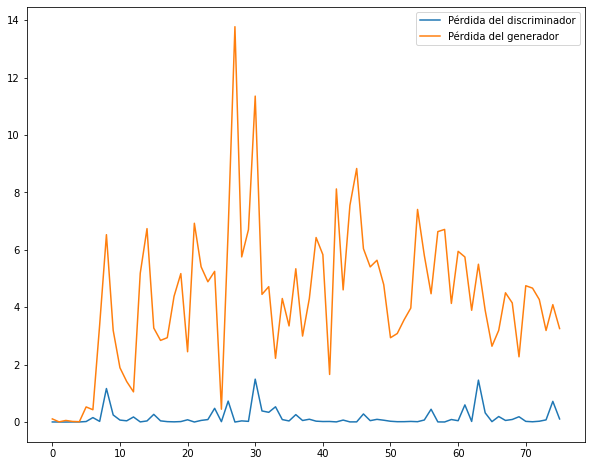

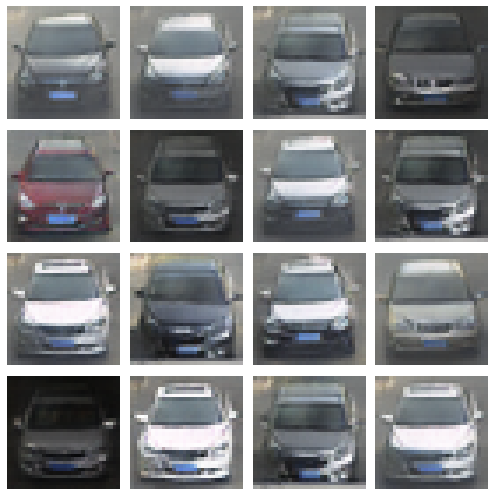











 38%|███▊      | 76/200 [44:29<1:12:24, 35.03s/it]









 38%|███▊      | 77/200 [45:04<1:11:33, 34.91s/it]









 39%|███▉      | 78/200 [45:39<1:10:49, 34.83s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

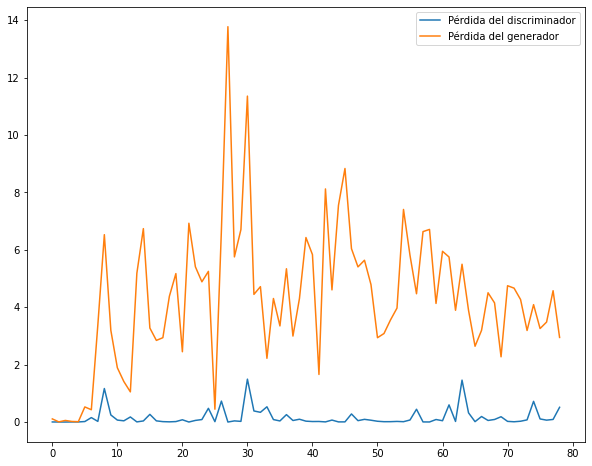

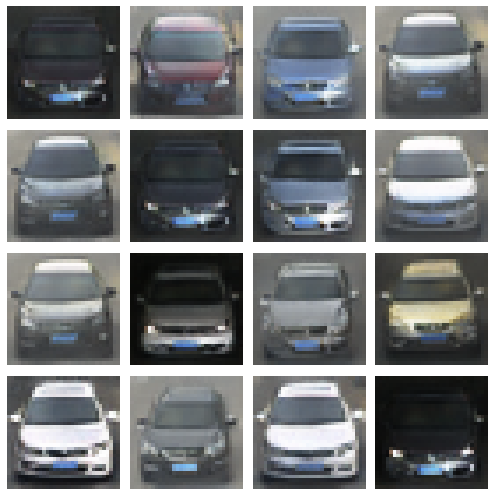











 40%|███▉      | 79/200 [46:14<1:10:31, 34.97s/it]









 40%|████      | 80/200 [46:48<1:09:41, 34.85s/it]









 40%|████      | 81/200 [47:23<1:08:55, 34.75s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

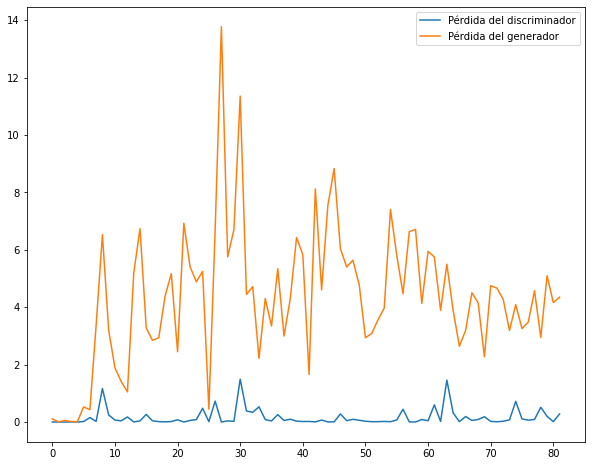

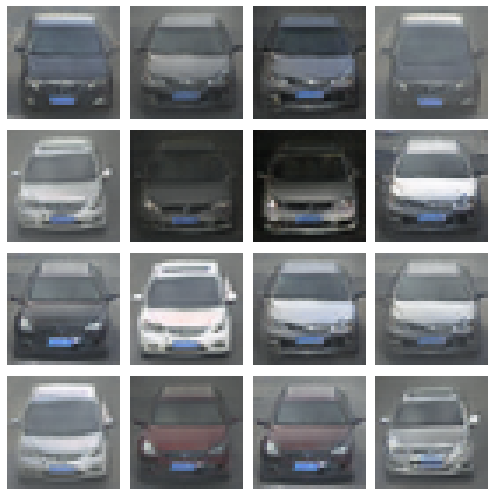











 41%|████      | 82/200 [47:58<1:08:36, 34.89s/it]









 42%|████▏     | 83/200 [48:33<1:07:53, 34.82s/it]









 42%|████▏     | 84/200 [49:08<1:07:29, 34.91s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

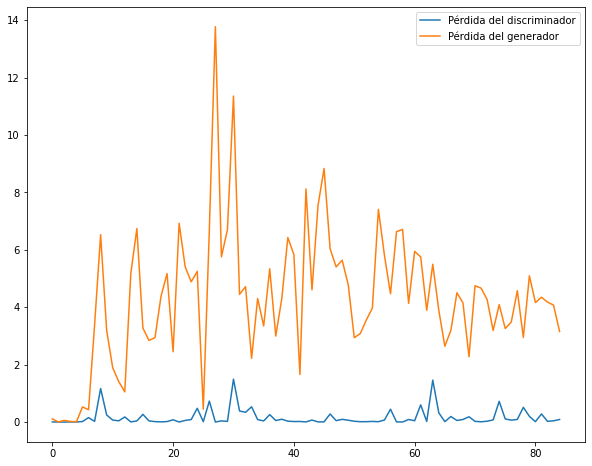

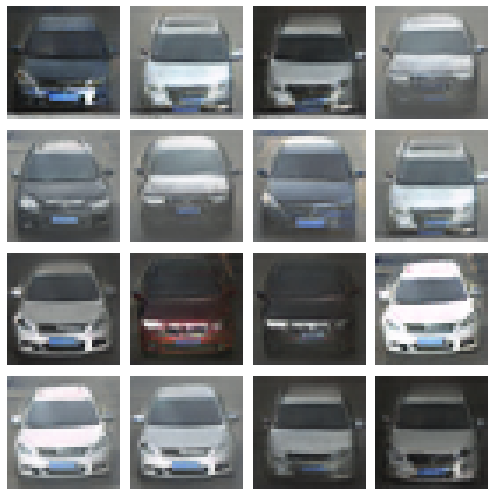











 42%|████▎     | 85/200 [49:43<1:07:05, 35.00s/it]









 43%|████▎     | 86/200 [50:18<1:06:20, 34.92s/it]









 44%|████▎     | 87/200 [50:53<1:05:41, 34.88s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

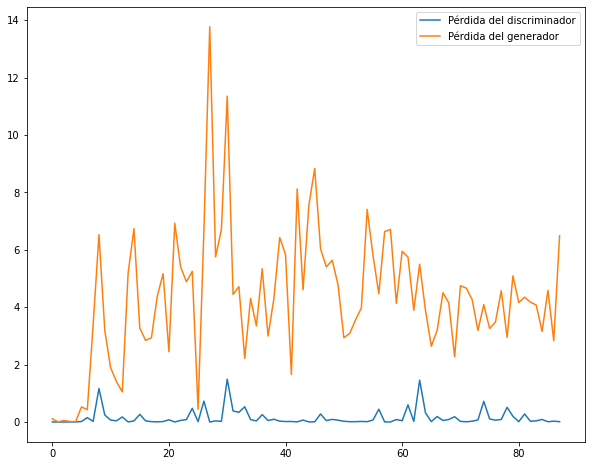

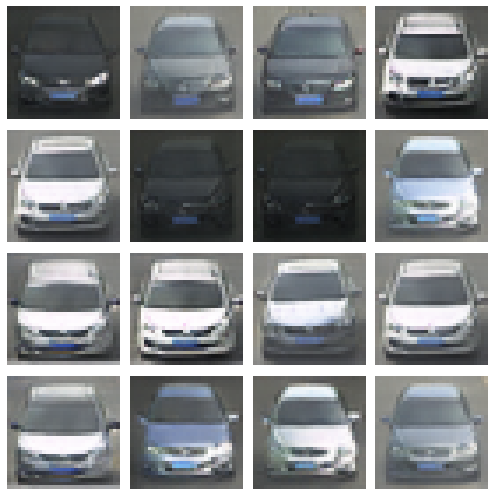











 44%|████▍     | 88/200 [51:28<1:05:15, 34.96s/it]









 44%|████▍     | 89/200 [52:02<1:04:25, 34.83s/it]









 45%|████▌     | 90/200 [52:37<1:03:40, 34.73s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

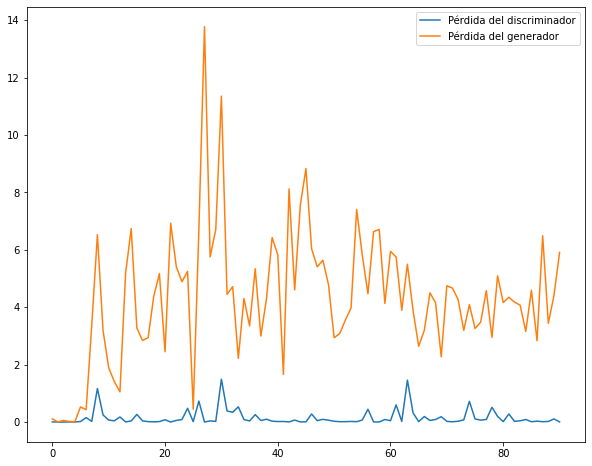

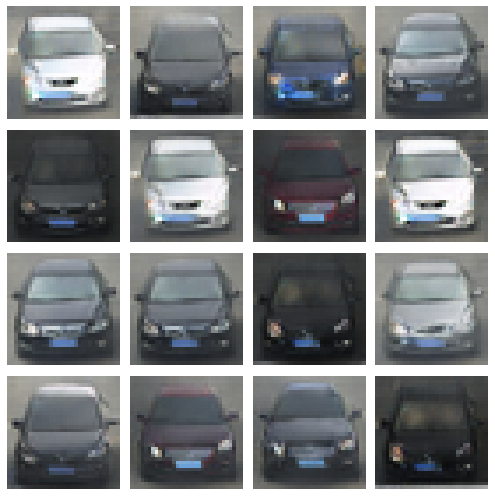











 46%|████▌     | 91/200 [53:12<1:03:19, 34.85s/it]









 46%|████▌     | 92/200 [53:46<1:02:33, 34.75s/it]









 46%|████▋     | 93/200 [54:21<1:02:04, 34.81s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

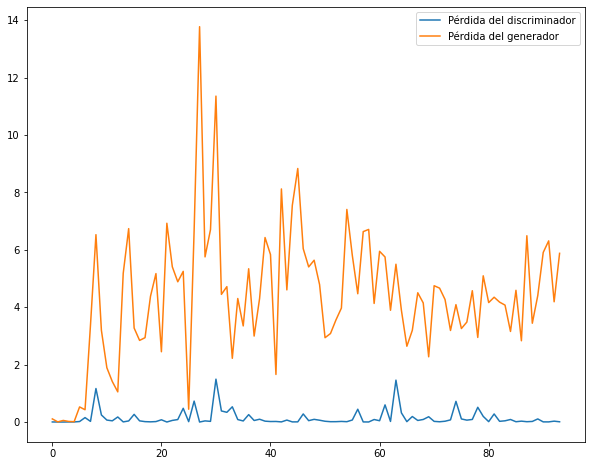

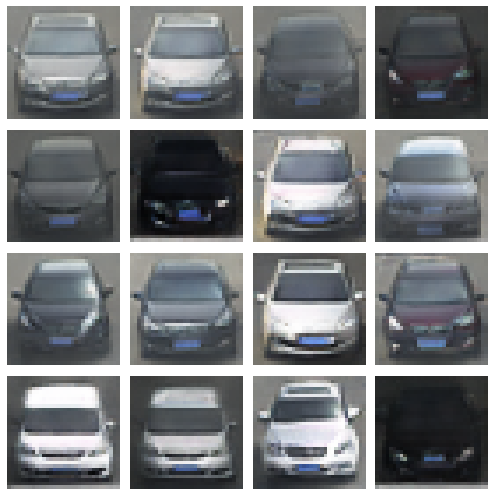











 47%|████▋     | 94/200 [54:57<1:01:49, 34.99s/it]









 48%|████▊     | 95/200 [55:31<1:01:01, 34.88s/it]









 48%|████▊     | 96/200 [56:06<1:00:20, 34.82s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

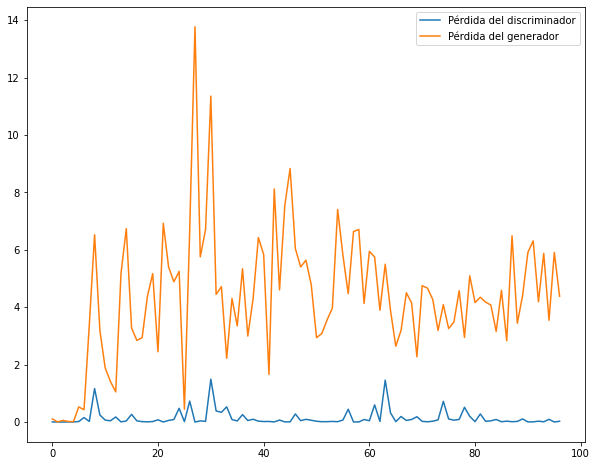

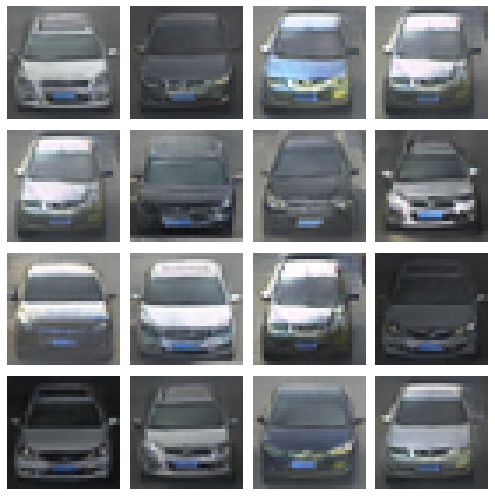











 48%|████▊     | 97/200 [56:41<59:56, 34.92s/it]  









 49%|████▉     | 98/200 [57:16<59:12, 34.83s/it]









 50%|████▉     | 99/200 [57:50<58:26, 34.72s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

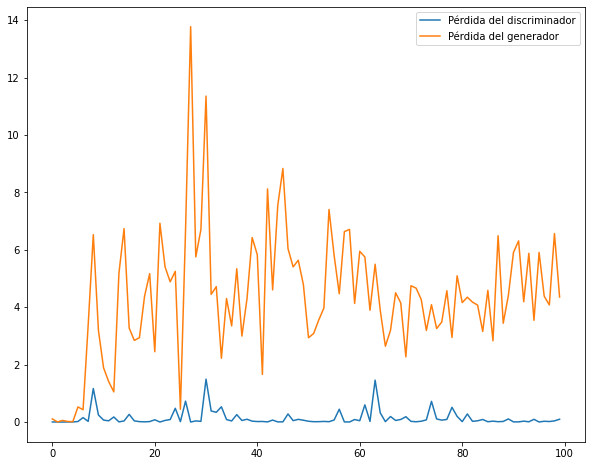

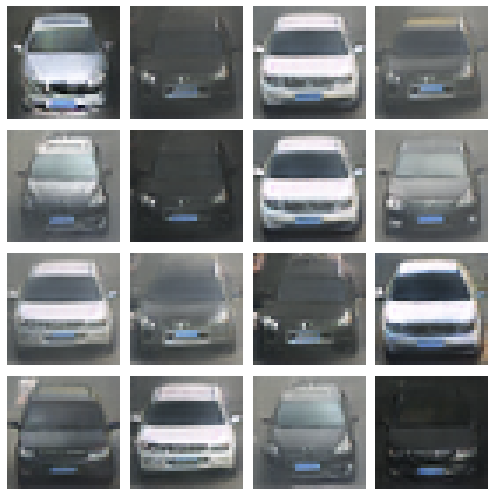











 50%|█████     | 100/200 [58:26<58:07, 34.87s/it]









 50%|█████     | 101/200 [59:00<57:20, 34.75s/it]









 51%|█████     | 102/200 [59:35<56:49, 34.80s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

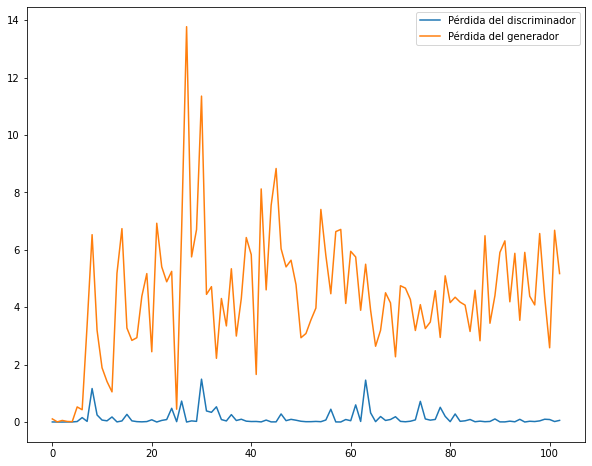

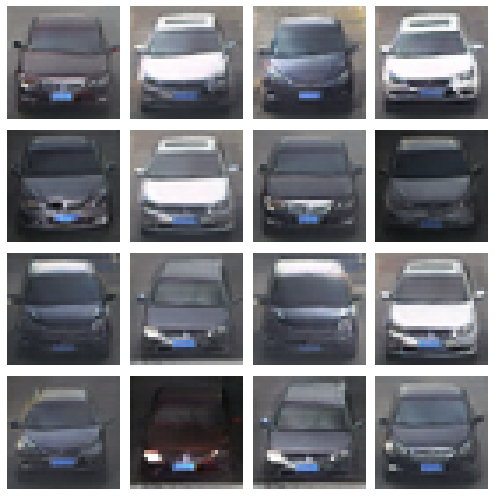











 52%|█████▏    | 103/200 [1:00:10<56:22, 34.87s/it]









 52%|█████▏    | 104/200 [1:00:45<55:38, 34.78s/it]









 52%|█████▎    | 105/200 [1:01:19<55:02, 34.76s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

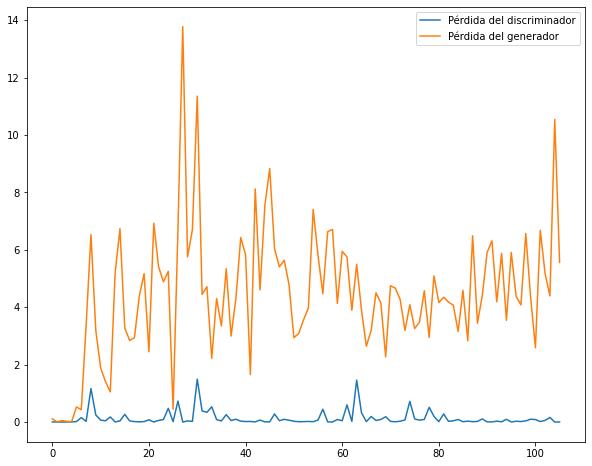

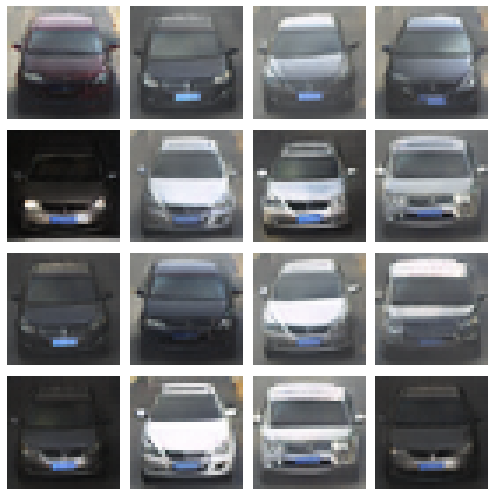











 53%|█████▎    | 106/200 [1:01:55<54:48, 34.98s/it]









 54%|█████▎    | 107/200 [1:02:29<54:03, 34.88s/it]









 54%|█████▍    | 108/200 [1:03:04<53:20, 34.79s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

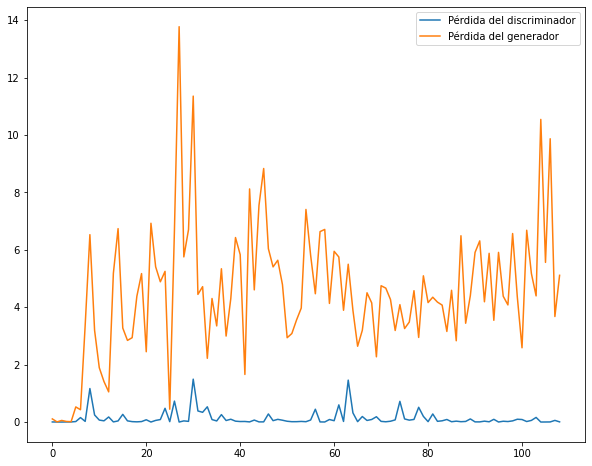

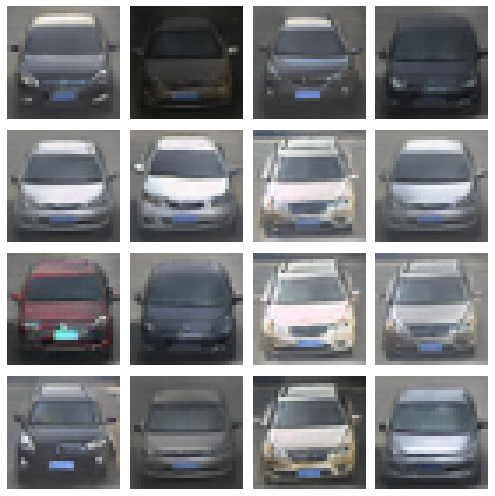











 55%|█████▍    | 109/200 [1:03:39<52:56, 34.91s/it]









 55%|█████▌    | 110/200 [1:04:14<52:21, 34.91s/it]









 56%|█████▌    | 111/200 [1:04:49<51:48, 34.93s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

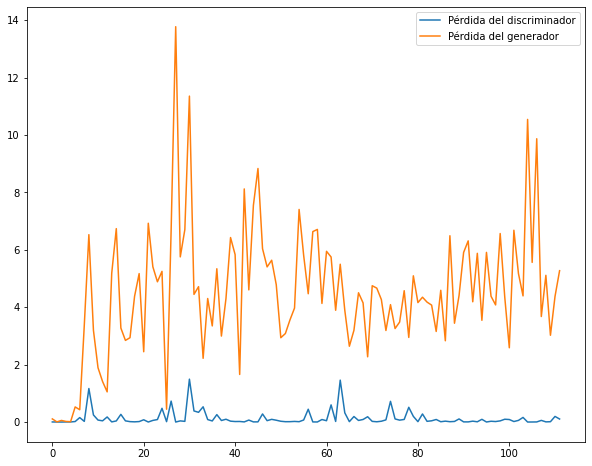

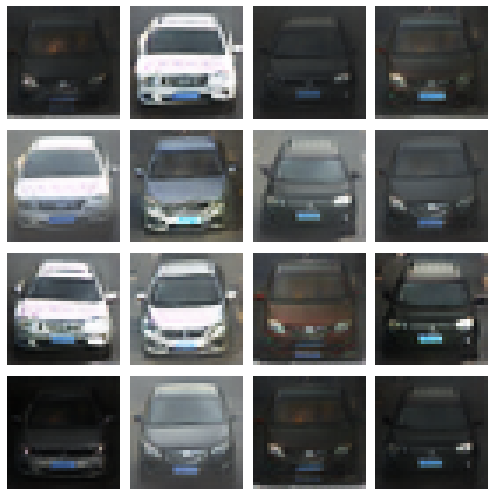











 56%|█████▌    | 112/200 [1:05:24<51:19, 35.00s/it]









 56%|█████▋    | 113/200 [1:05:59<50:38, 34.93s/it]









 57%|█████▋    | 114/200 [1:06:34<49:55, 34.83s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

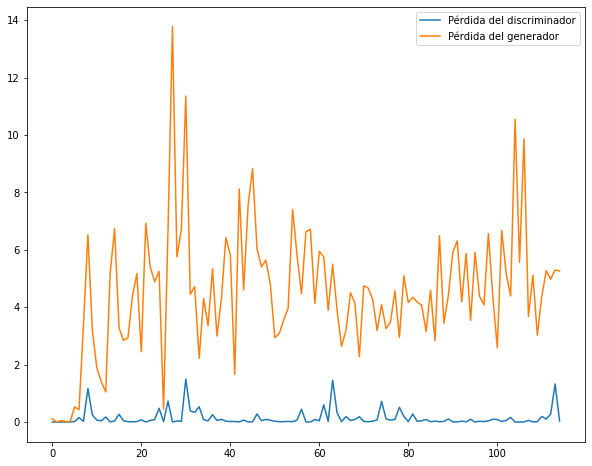

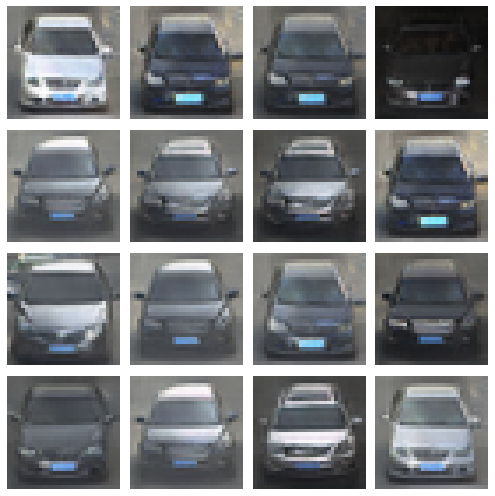











 57%|█████▊    | 115/200 [1:07:09<49:26, 34.91s/it]









 58%|█████▊    | 116/200 [1:07:43<48:48, 34.86s/it]









 58%|█████▊    | 117/200 [1:08:18<48:04, 34.76s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

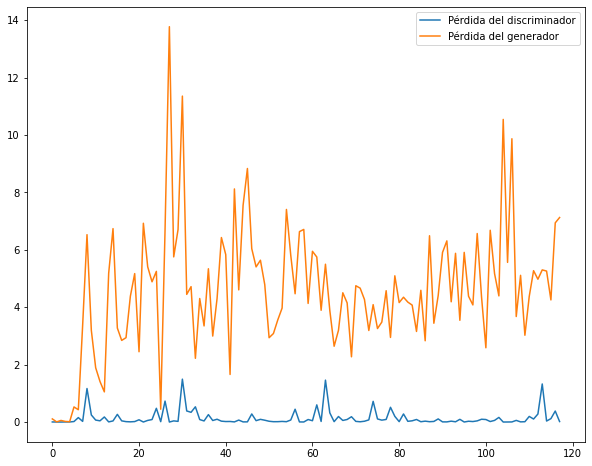

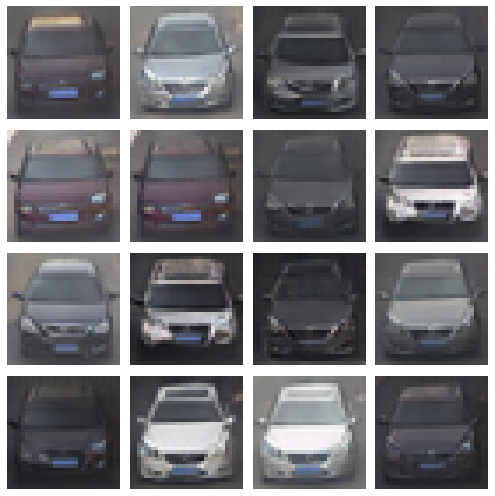











 59%|█████▉    | 118/200 [1:08:53<47:41, 34.90s/it]









 60%|█████▉    | 119/200 [1:09:28<46:58, 34.80s/it]









 60%|██████    | 120/200 [1:10:03<46:27, 34.84s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

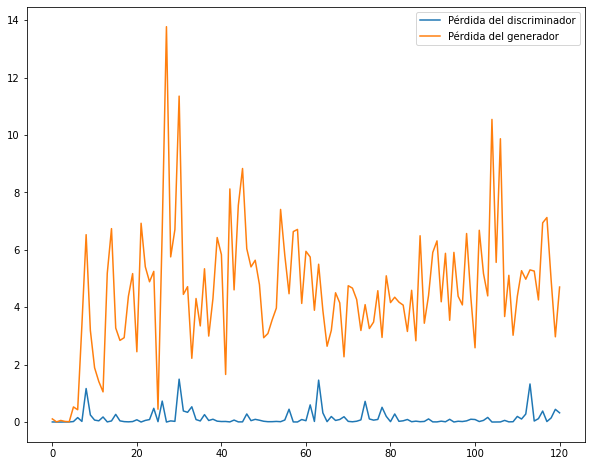

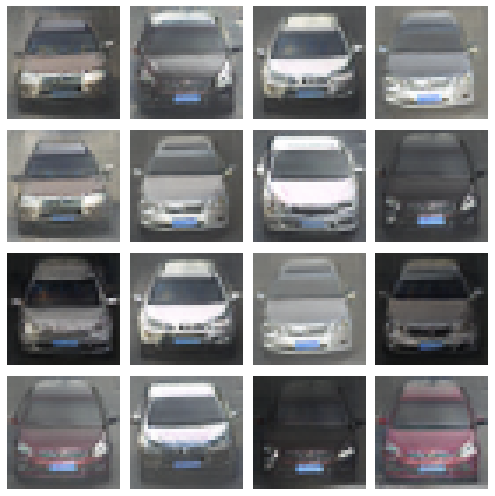











 60%|██████    | 121/200 [1:10:38<46:01, 34.96s/it]









 61%|██████    | 122/200 [1:11:13<45:21, 34.89s/it]









 62%|██████▏   | 123/200 [1:11:47<44:39, 34.80s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

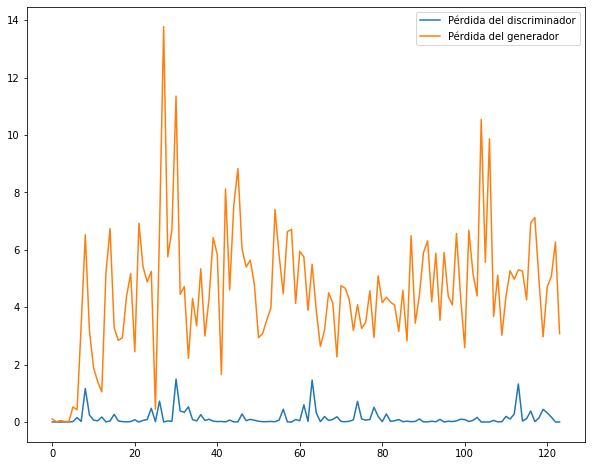

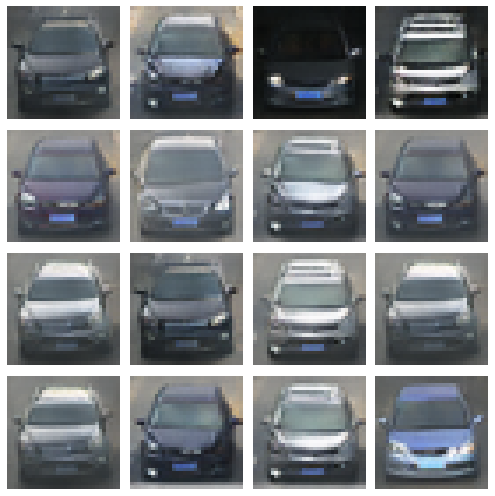











 62%|██████▏   | 124/200 [1:12:22<44:10, 34.88s/it]









 62%|██████▎   | 125/200 [1:12:57<43:28, 34.78s/it]









 63%|██████▎   | 126/200 [1:13:31<42:48, 34.71s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

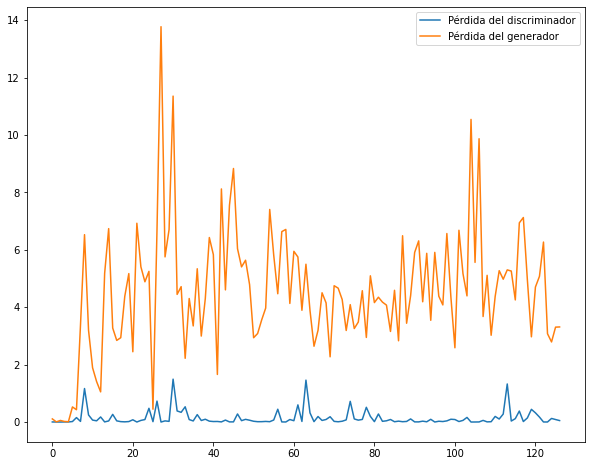

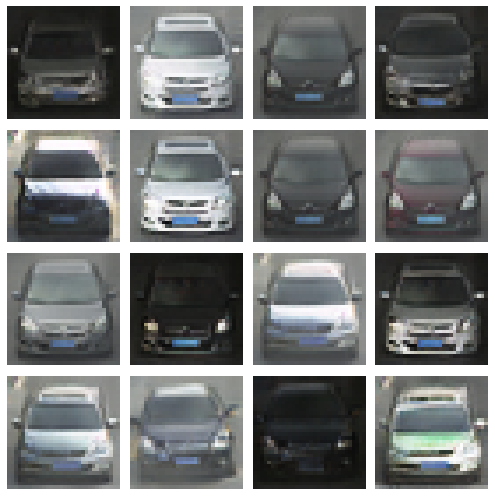











 64%|██████▎   | 127/200 [1:14:07<42:28, 34.92s/it]









 64%|██████▍   | 128/200 [1:14:41<41:49, 34.86s/it]









 64%|██████▍   | 129/200 [1:15:16<41:14, 34.86s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

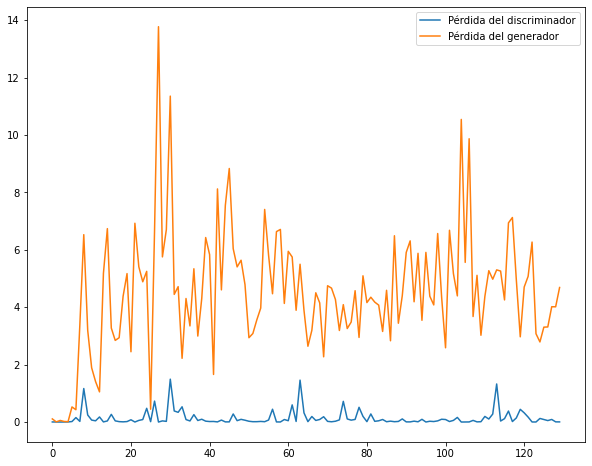

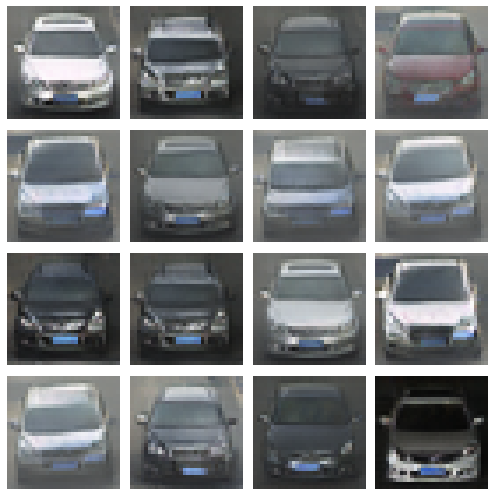











 65%|██████▌   | 130/200 [1:15:52<40:48, 34.98s/it]









 66%|██████▌   | 131/200 [1:16:26<40:07, 34.90s/it]









 66%|██████▌   | 132/200 [1:17:01<39:27, 34.81s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

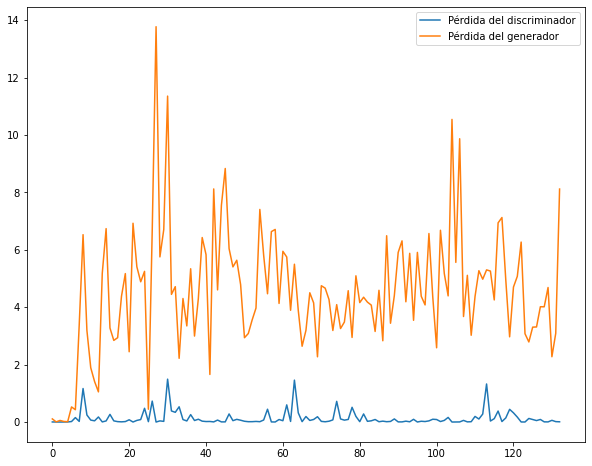

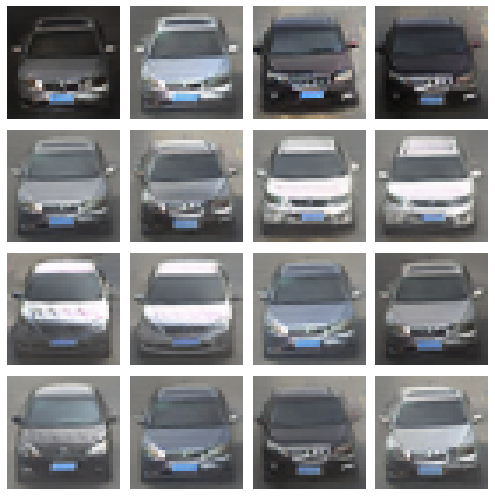











 66%|██████▋   | 133/200 [1:17:36<38:58, 34.91s/it]









 67%|██████▋   | 134/200 [1:18:11<38:16, 34.79s/it]









 68%|██████▊   | 135/200 [1:18:45<37:38, 34.74s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

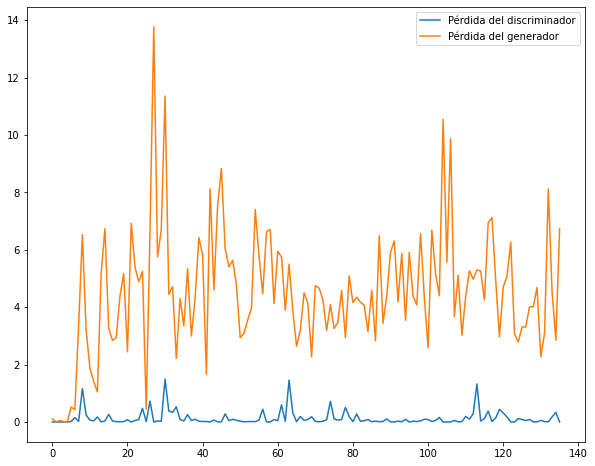

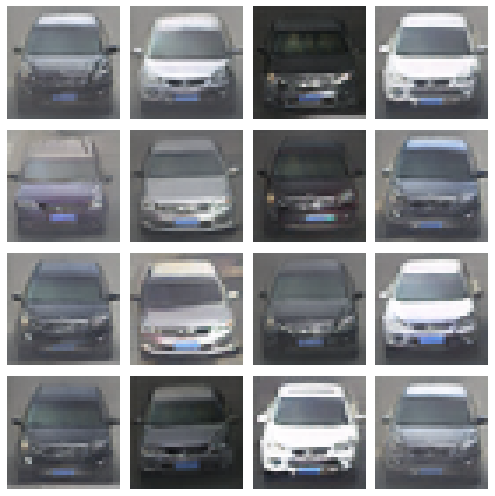











 68%|██████▊   | 136/200 [1:19:20<37:10, 34.85s/it]









 68%|██████▊   | 137/200 [1:19:55<36:34, 34.84s/it]









 69%|██████▉   | 138/200 [1:20:30<35:56, 34.79s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

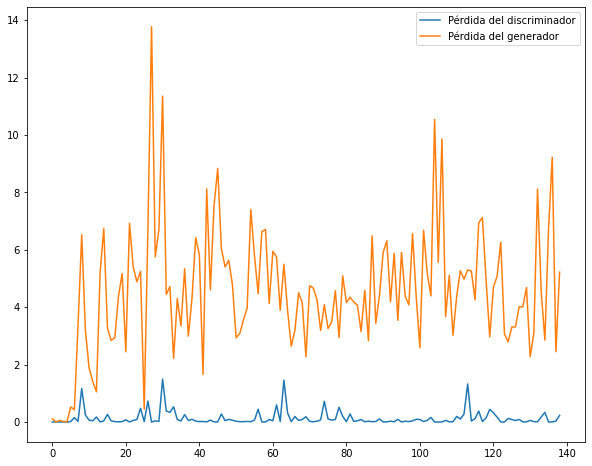

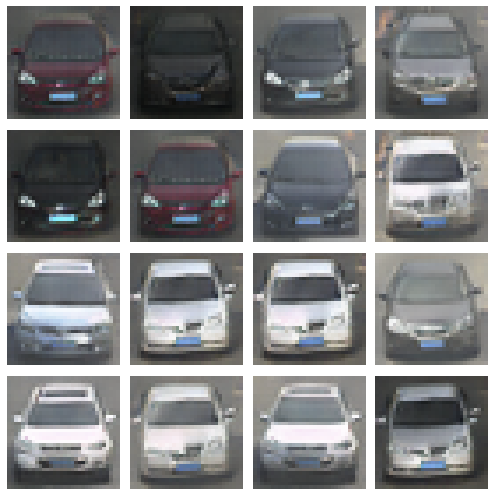











 70%|██████▉   | 139/200 [1:21:05<35:29, 34.90s/it]









 70%|███████   | 140/200 [1:21:40<34:48, 34.81s/it]









 70%|███████   | 141/200 [1:22:14<34:08, 34.72s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

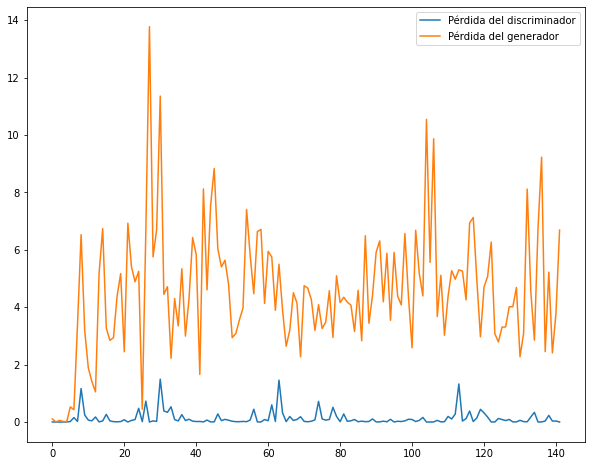

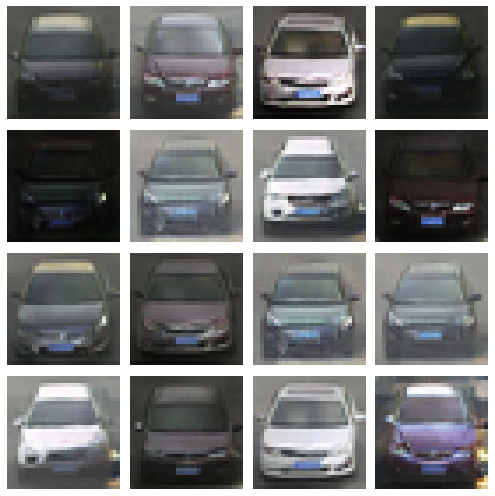











 71%|███████   | 142/200 [1:22:49<33:41, 34.85s/it]









 72%|███████▏  | 143/200 [1:23:24<32:59, 34.74s/it]









 72%|███████▏  | 144/200 [1:23:58<32:22, 34.69s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

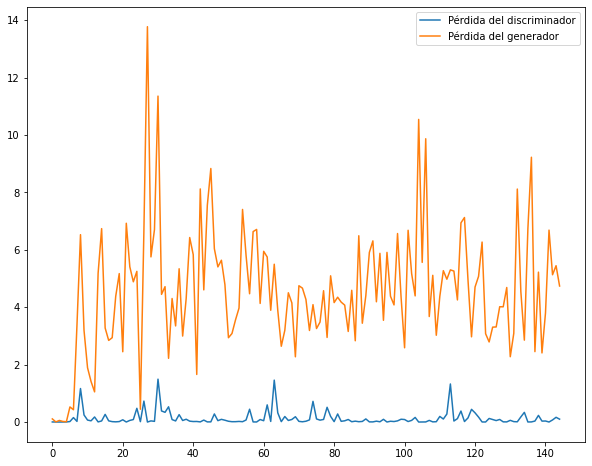

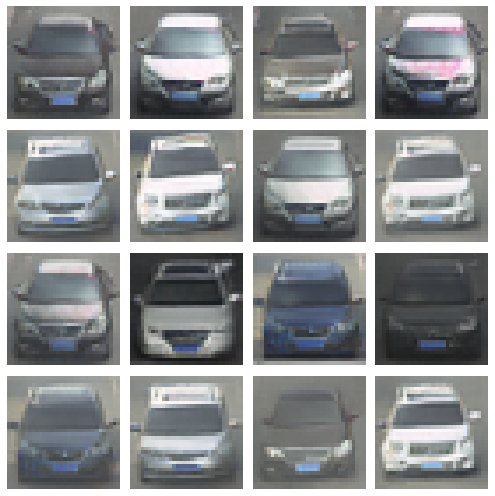











 72%|███████▎  | 145/200 [1:24:34<32:00, 34.92s/it]









 73%|███████▎  | 146/200 [1:25:09<31:25, 34.92s/it]









 74%|███████▎  | 147/200 [1:25:43<30:48, 34.88s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

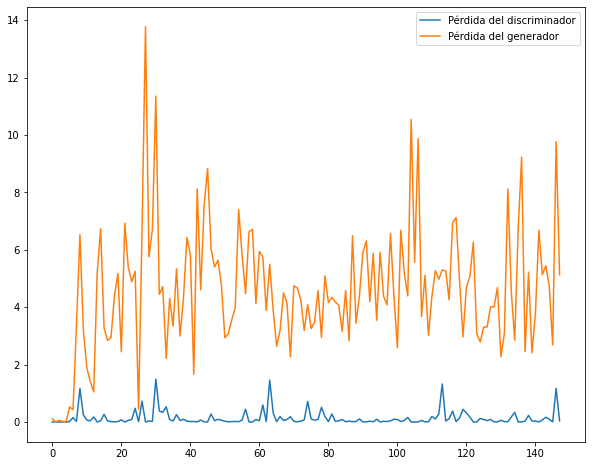

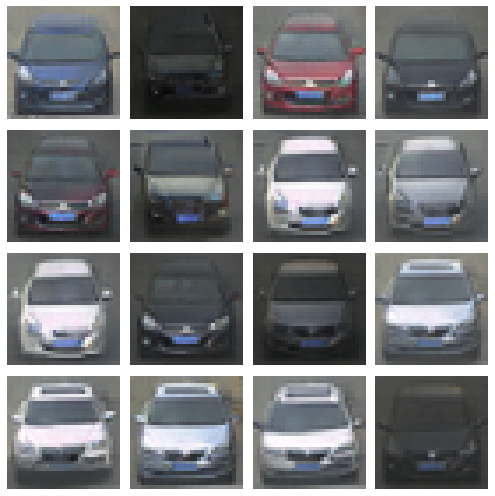











 74%|███████▍  | 148/200 [1:26:19<30:19, 34.98s/it]









 74%|███████▍  | 149/200 [1:26:53<29:36, 34.84s/it]









 75%|███████▌  | 150/200 [1:27:28<28:56, 34.73s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

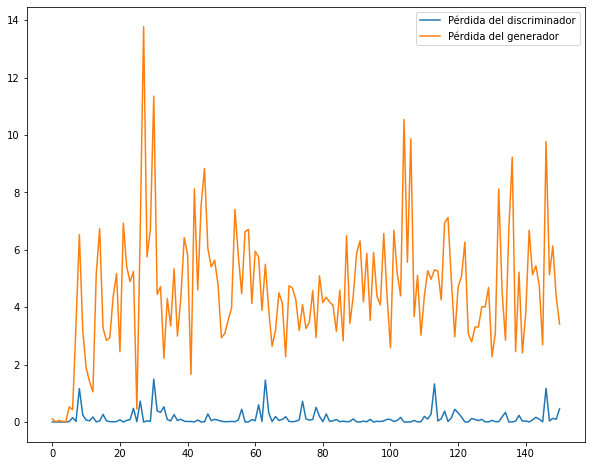

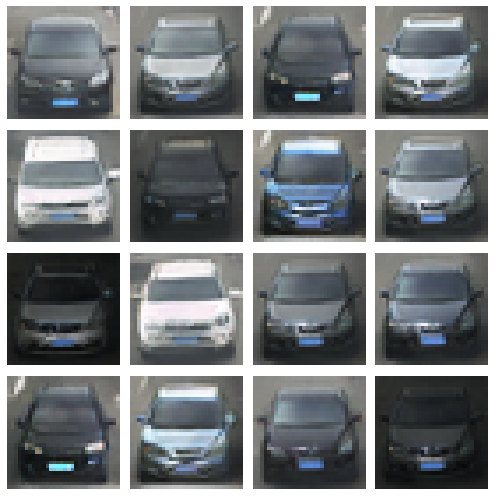











 76%|███████▌  | 151/200 [1:28:03<28:28, 34.86s/it]









 76%|███████▌  | 152/200 [1:28:37<27:48, 34.75s/it]









 76%|███████▋  | 153/200 [1:29:12<27:10, 34.69s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

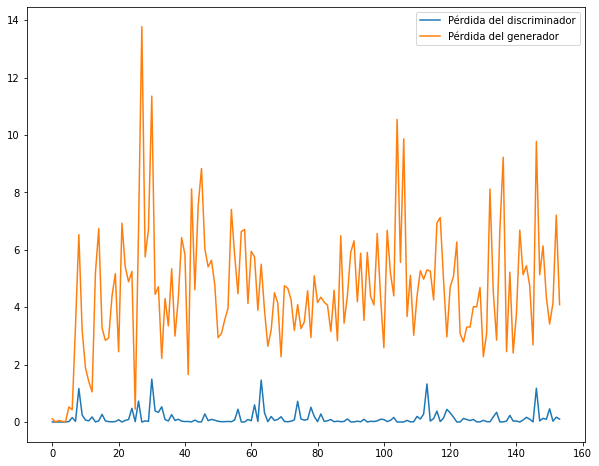

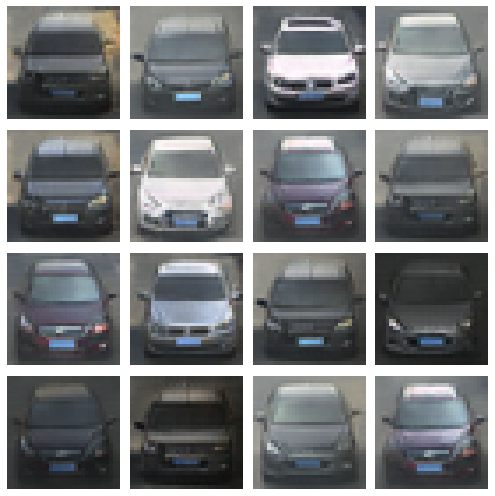











 77%|███████▋  | 154/200 [1:29:47<26:40, 34.80s/it]









 78%|███████▊  | 155/200 [1:30:22<26:06, 34.80s/it]









 78%|███████▊  | 156/200 [1:30:56<25:27, 34.72s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

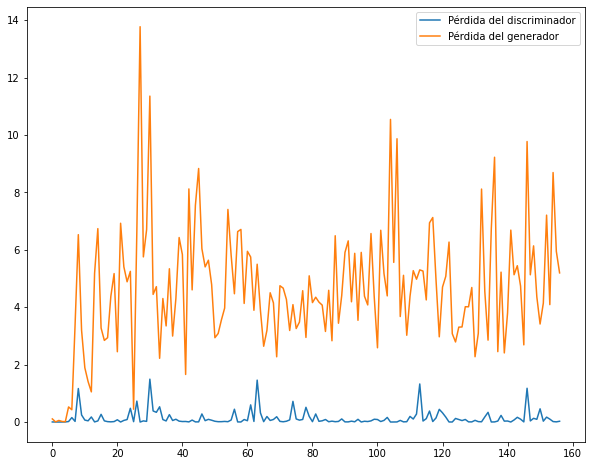

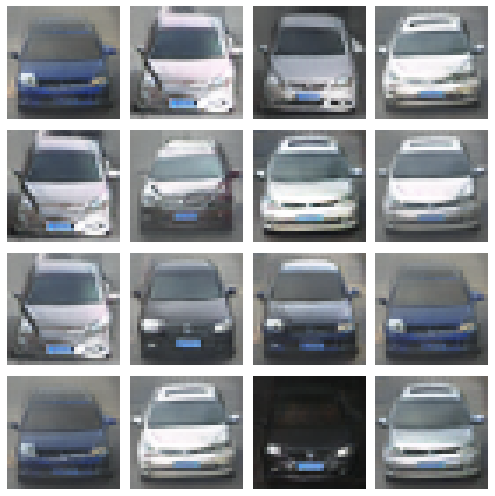











 78%|███████▊  | 157/200 [1:31:31<25:00, 34.88s/it]









 79%|███████▉  | 158/200 [1:32:06<24:21, 34.79s/it]









 80%|███████▉  | 159/200 [1:32:40<23:41, 34.68s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

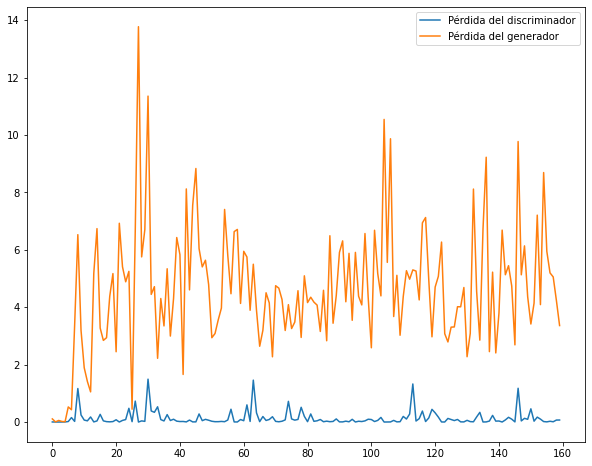

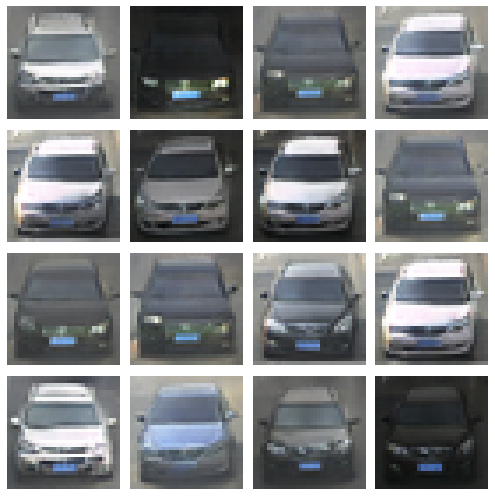











 80%|████████  | 160/200 [1:33:16<23:12, 34.82s/it]









 80%|████████  | 161/200 [1:33:50<22:34, 34.72s/it]









 81%|████████  | 162/200 [1:34:25<21:57, 34.67s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

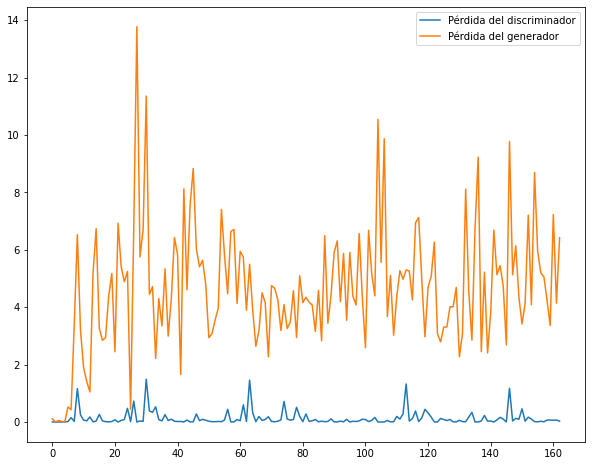

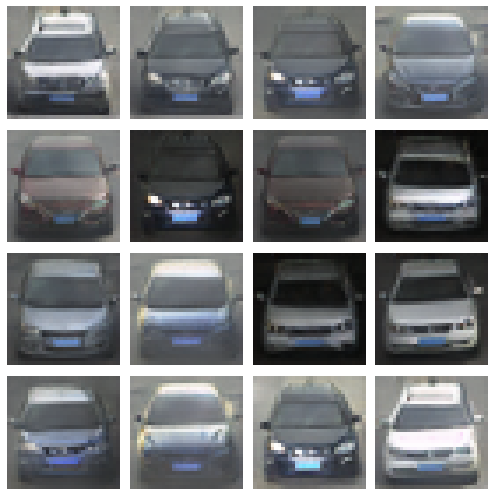











 82%|████████▏ | 163/200 [1:35:00<21:31, 34.90s/it]









 82%|████████▏ | 164/200 [1:35:35<20:56, 34.91s/it]









 82%|████████▎ | 165/200 [1:36:10<20:18, 34.81s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

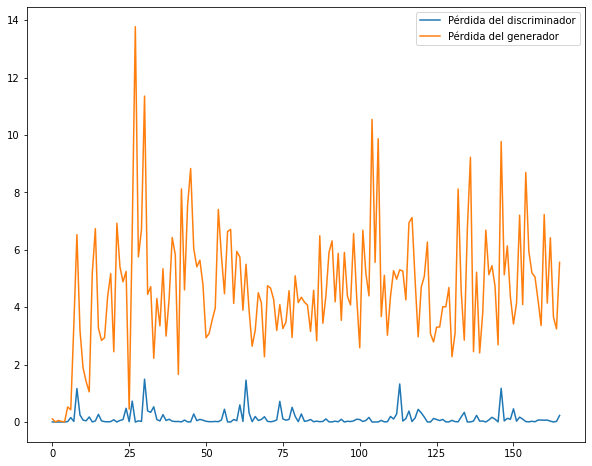

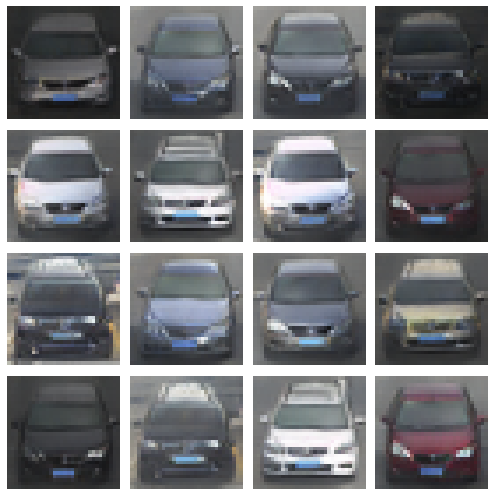











 83%|████████▎ | 166/200 [1:36:45<19:47, 34.94s/it]









 84%|████████▎ | 167/200 [1:37:19<19:09, 34.83s/it]









 84%|████████▍ | 168/200 [1:37:54<18:31, 34.73s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

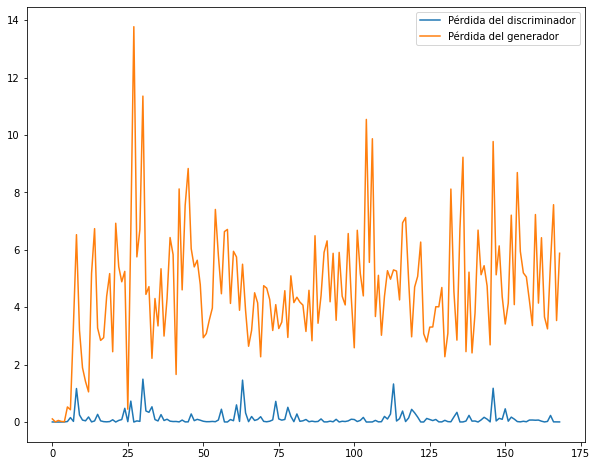

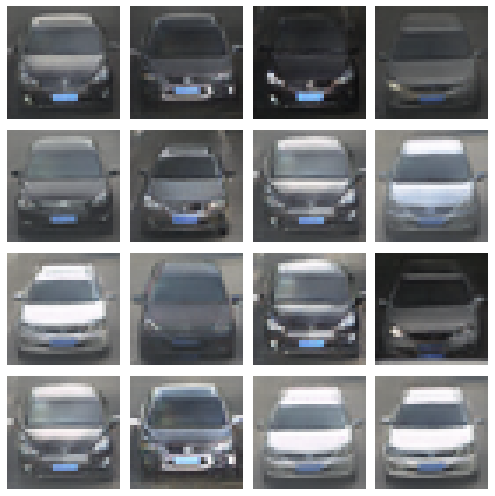











 84%|████████▍ | 169/200 [1:38:29<18:01, 34.89s/it]









 85%|████████▌ | 170/200 [1:39:04<17:23, 34.79s/it]









 86%|████████▌ | 171/200 [1:39:38<16:47, 34.73s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

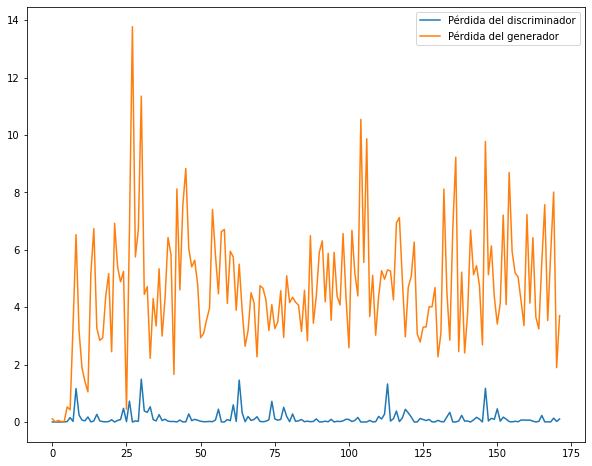

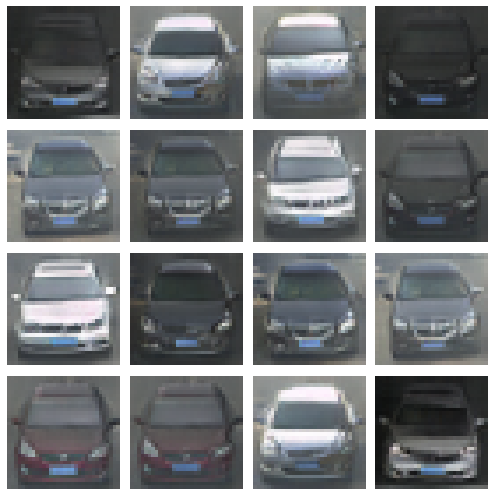











 86%|████████▌ | 172/200 [1:40:14<16:16, 34.89s/it]









 86%|████████▋ | 173/200 [1:40:49<15:42, 34.91s/it]









 87%|████████▋ | 174/200 [1:41:23<15:05, 34.82s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

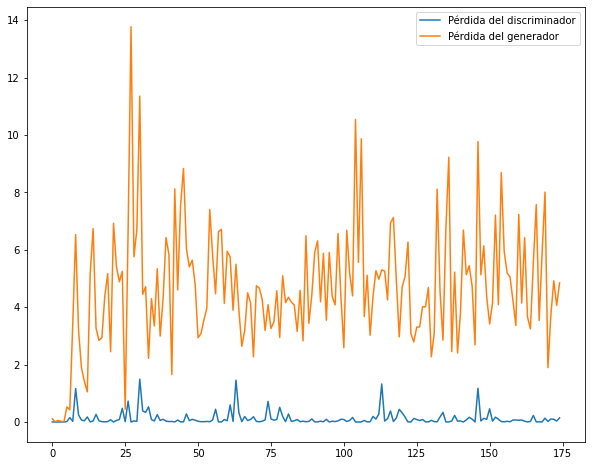

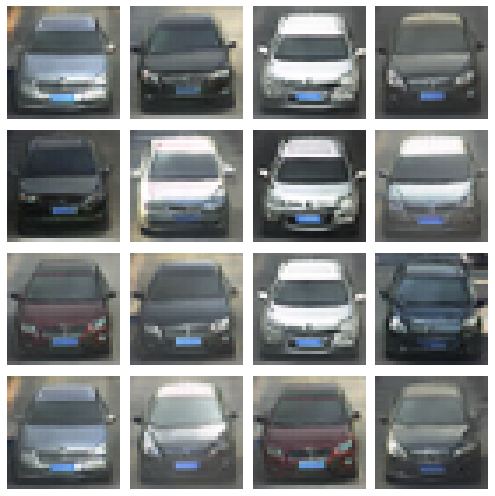











 88%|████████▊ | 175/200 [1:41:58<14:33, 34.96s/it]









 88%|████████▊ | 176/200 [1:42:33<13:56, 34.85s/it]









 88%|████████▊ | 177/200 [1:43:08<13:19, 34.74s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

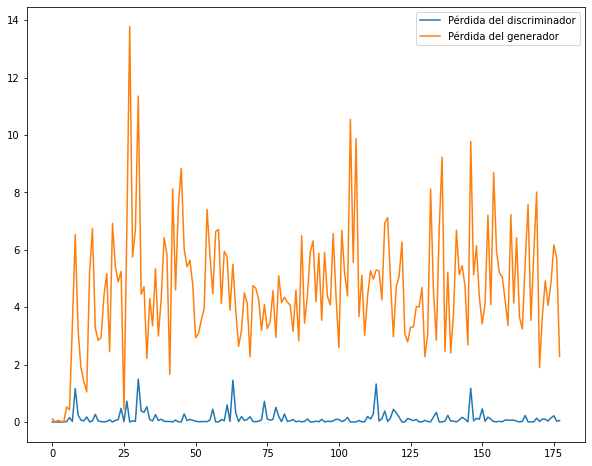

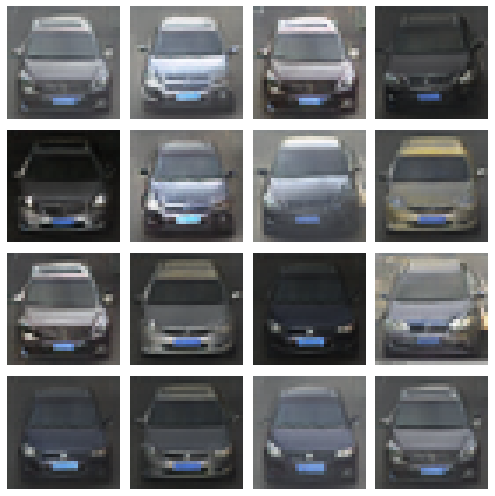











 89%|████████▉ | 178/200 [1:43:43<12:46, 34.86s/it]









 90%|████████▉ | 179/200 [1:44:18<12:12, 34.89s/it]









 90%|█████████ | 180/200 [1:44:52<11:36, 34.80s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

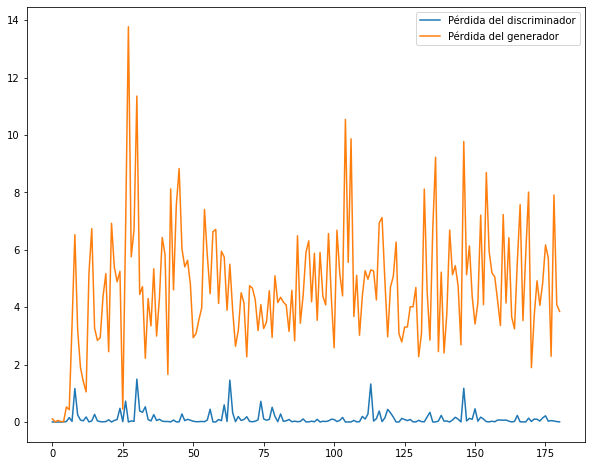

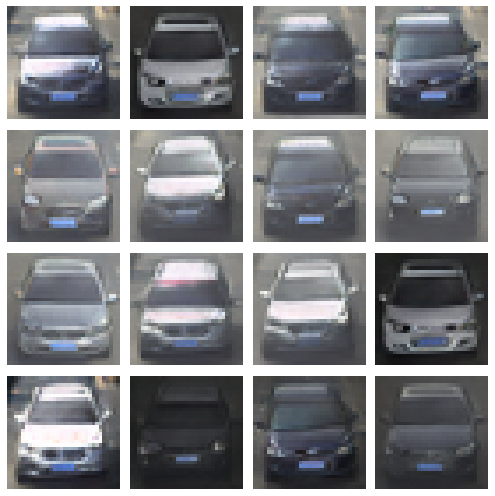











 90%|█████████ | 181/200 [1:45:27<11:03, 34.91s/it]









 91%|█████████ | 182/200 [1:46:02<10:28, 34.92s/it]









 92%|█████████▏| 183/200 [1:46:37<09:52, 34.85s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

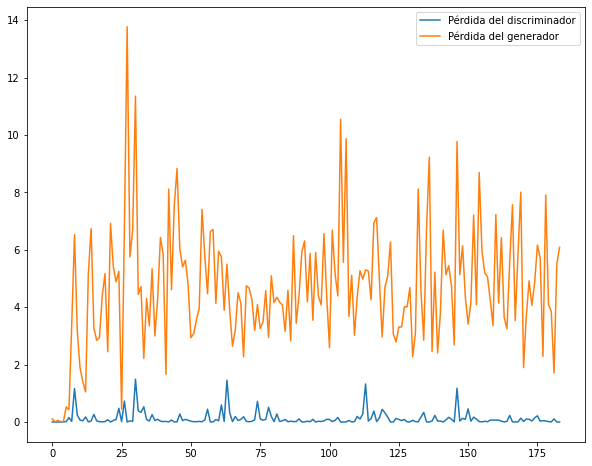

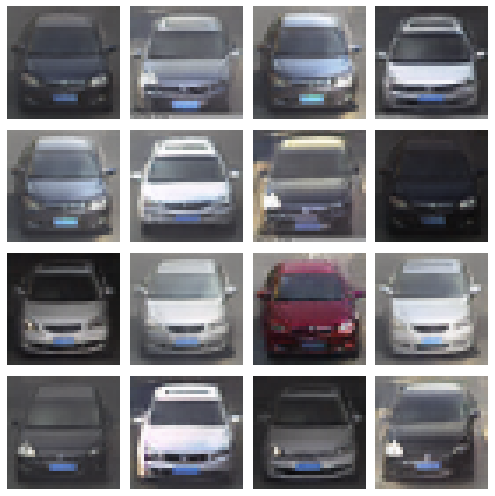











 92%|█████████▏| 184/200 [1:47:12<09:18, 34.94s/it]









 92%|█████████▎| 185/200 [1:47:47<08:42, 34.84s/it]









 93%|█████████▎| 186/200 [1:48:21<08:06, 34.77s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

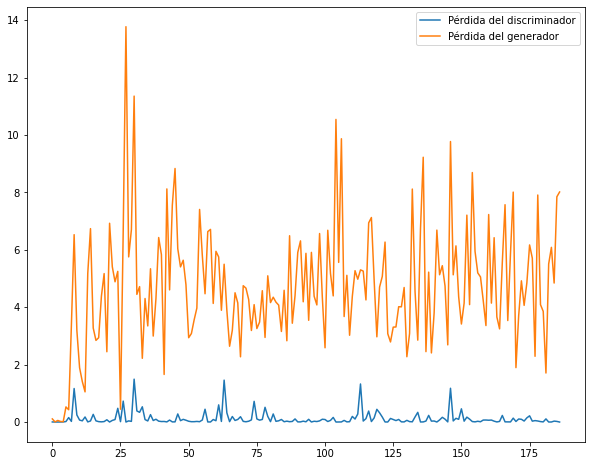

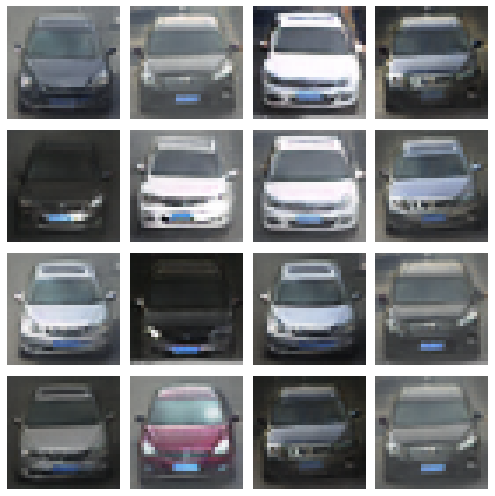











 94%|█████████▎| 187/200 [1:48:57<07:33, 34.91s/it]









 94%|█████████▍| 188/200 [1:49:31<06:58, 34.85s/it]









 94%|█████████▍| 189/200 [1:50:06<06:22, 34.80s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

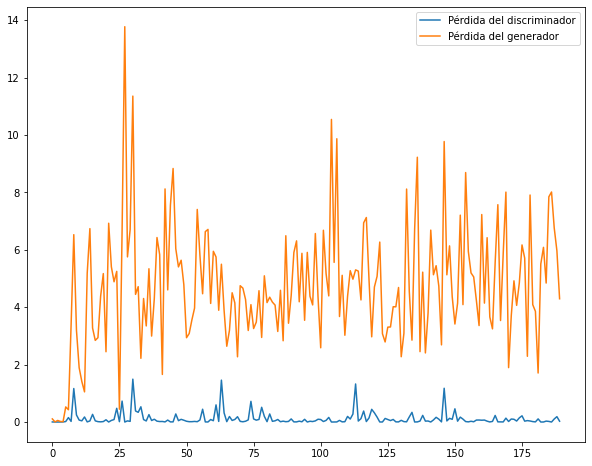

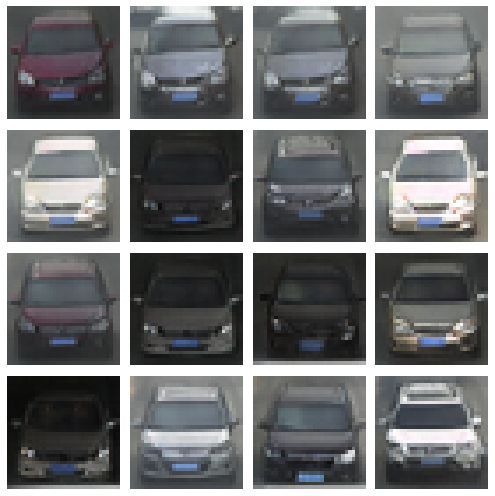











 95%|█████████▌| 190/200 [1:50:41<05:49, 34.99s/it]









 96%|█████████▌| 191/200 [1:51:16<05:14, 34.97s/it]









 96%|█████████▌| 192/200 [1:51:51<04:39, 34.90s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

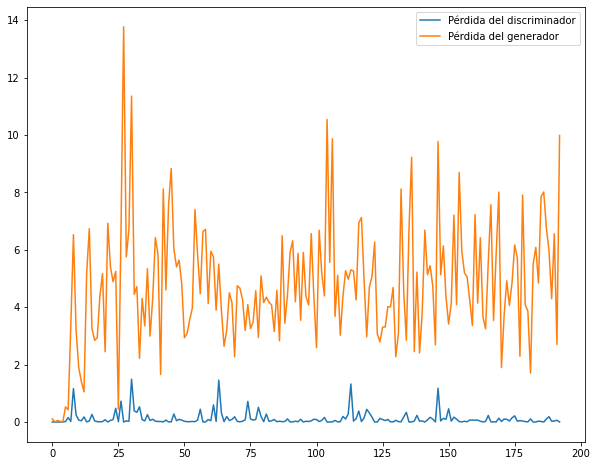

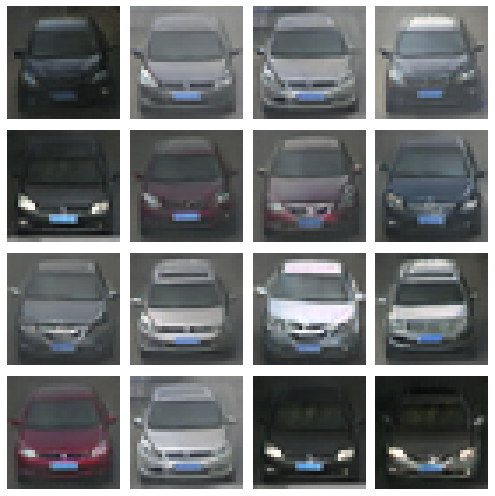











 96%|█████████▋| 193/200 [1:52:26<04:04, 34.98s/it]









 97%|█████████▋| 194/200 [1:53:01<03:29, 34.84s/it]









 98%|█████████▊| 195/200 [1:53:35<02:53, 34.79s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

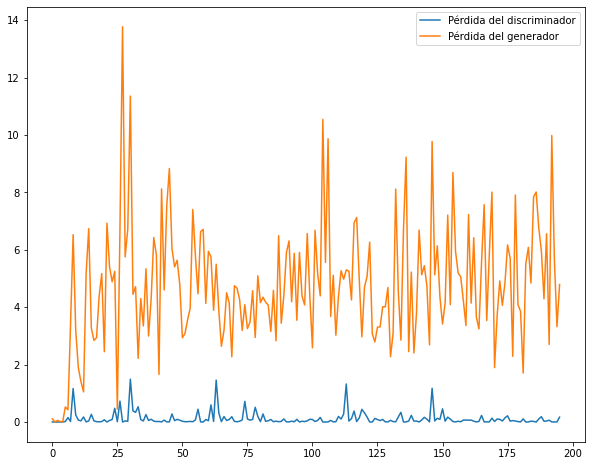

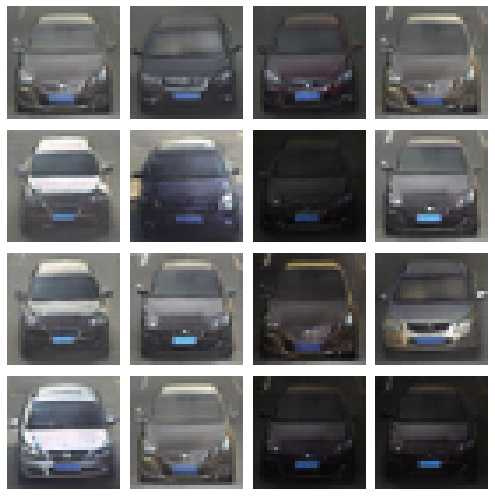











 98%|█████████▊| 196/200 [1:54:11<02:19, 34.99s/it]









 98%|█████████▊| 197/200 [1:54:46<01:44, 34.88s/it]









 99%|█████████▉| 198/200 [1:55:20<01:09, 34.75s/it]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

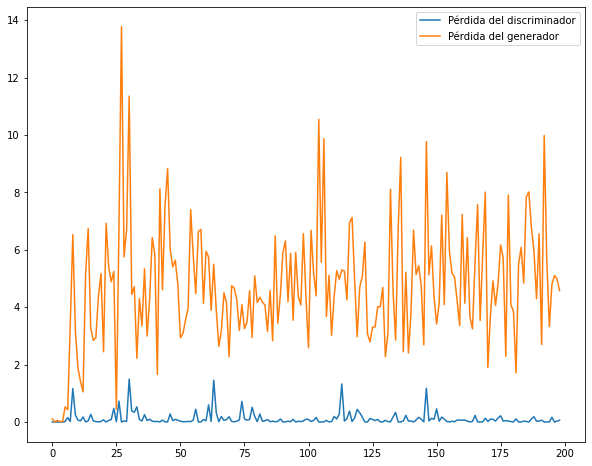

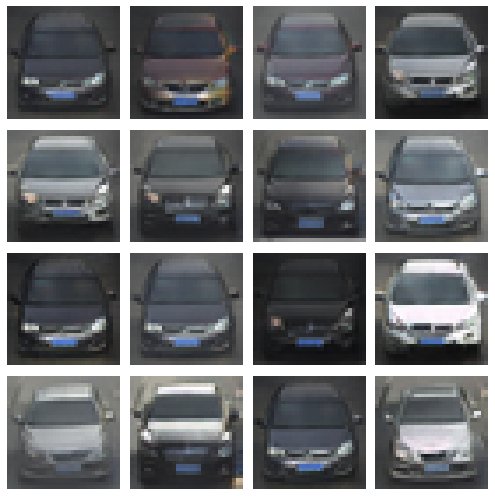











100%|█████████▉| 199/200 [1:55:55<00:34, 34.89s/it]









100%|██████████| 200/200 [1:56:30<00:00, 34.95s/it]



X_train.shape: (30526, 32, 32, 3)
n_epochs: 200
batch_size: 32
batch_per_epoch: 953
CPU times: user 1h 52min 27s, sys: 16min 30s, total: 2h 8min 58s
Wall time: 1h 56min 30s


In [ ]:
%%time

# esto se usa para probar cosas con mayor rapidez
if n_images_to_train != None:
  X_train = X_train[:n_images_to_train]

n_epochs = 200
batch_size = 32

train(generator, discriminator, gan, n_epochs, batch_size)

In [ ]:
# Guardado del modelo

!mkdir -p saved_model
generator.save('saved_model/model_gen.h5')

## 6 - Generar imágenes nuevas

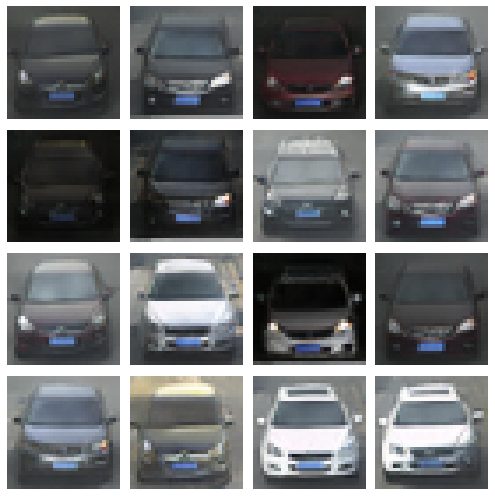

In [ ]:
# Se muestra una grilla con algunas imagenes generadas
plot_gen()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


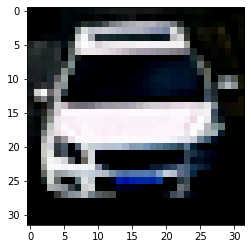

In [ ]:
# Se genera una única imagen
noise = np.random.normal(0,1,size=[1,100])
generated_image = generator.predict(noise)[0]
generated_image = (generated_image + 1) / 2
plot_image(generated_image)